# Nonlinear time series analysis

<img src="media/cover.png" style="width: 40%; display: block; margin: auto;">

> "*Something as small as the flutter of a butterfly’s wing can ultimately cause a typhoon halfway around the world.*"

<div style="text-align: right; font-size: 15px;">--Chaos theory</div>

## Overview

In this lecture we will cover the following topics.

- Dynamical systems and nonlinear dynamics.
- Bifurcation diagrams.
- Chaotic systems.
- Higher-dimensional continuous-time systems.
- Phase (state) space of a system.
- Fractal dimensions.
- Phase space reconstruction and Taken's embedding theorem.
- Forecasting nonlinear time series.

In [1]:
import sys

# Install dependencies if the notebook is running in Colab
#if 'google.colab' in sys.modules:
#    !pip install -U -qq reservoir_computing tsa_course

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.integrate import solve_ivp
from sklearn.neighbors import NearestNeighbors 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from reservoir_computing.reservoir import Reservoir
from reservoir_computing.utils import make_forecasting_dataset
from tsa_course.lecture11 import computeLE, plot_bifurcation_diagram 
np.random.seed(0)

---

## Dynamical Systems

- A dynamic system is a set of functions (rules, equations) specifying how variables change over time.
- For example: 

$$\begin{aligned}x(t+1) &= a \cdot x(t) + b \cdot y(t) \\ y(t+1) &= c \cdot x(t)\end{aligned}$$ 

- Here, $x$ and $y$ represent the *variables* of a 2-dimensional system, while $a,b,c$ are the *parameters*.

- Variables change over time, parameters do not.
- In a *discrete* system, variables change at times that are multiple of a integer.
- In a *continuous* system, the time index can assume real values, meaning that the variables can assume different values at each possible time.
- The system can be *stochastic* (one set of rules, many realizations) or *deterministic* (one set of rules, one realization).

- The *state* of a dynamic system at time $t$ is specified by the current value of its variables $x(t), y(t), \dots$
- The process of calculating the new state of a discrete system is called *iteration*.
- To evaluate how a system behaves, we need the functions, the parameter values, and the *initial conditions*, e.g., $x(0), y(0), \dots$

- Let's consider a classic example: the *alpha model*.
- It specifies how $q(t)$, the probability of making an error on trial $t$, changes from one trial to the next: 

$$q(t+1) = \beta \cdot q(t)$$

- The new error probability is diminished by $\beta \in (0,1)$.
- Starting from the initial conditions, we iterate the equations of our system and obtain a time series of system states.

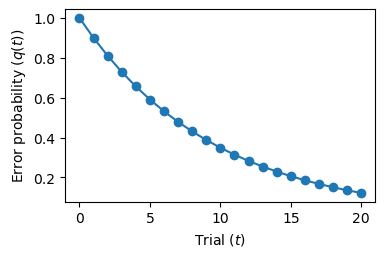

In [3]:
def alpha(beta, q):
    return beta * q # Sytem equation

beta = 0.9          # System parameter
q = [1]             # Initial condition

for _ in range(20):
    q.append(alpha(beta, q[-1])) # Iteration

fig = plt.figure(figsize=(4, 2.5))
plt.plot(q, 'o-')
plt.xlabel('Trial ($t$)')
plt.ylabel('Error probability ($q(t)$)')
plt.show()

---

## Non-linear Dynamical Systems

- Linear systems are those with linear state updates equations, i.e., something of the form $y(t) = a x(t) + b$.
- The alpha model is linear.
- Do not be confused by the non-linear curve we draw before: that is the *behavior* of the system, not the functions that specify its changes.

### The logistic map

- Is a very famous equation to describe the growth of a population.
- Is a non-linear model.
- Is often used to introduce the notion of *chaos*.

- Let's first use a simple linear model to describe the population growth 

$$x(t+1) = r x(t)$$ 

- where $r$ is the growth rate.
- With this model, if $r>1$ the population grows exponentially without limit, which is not very realistic.

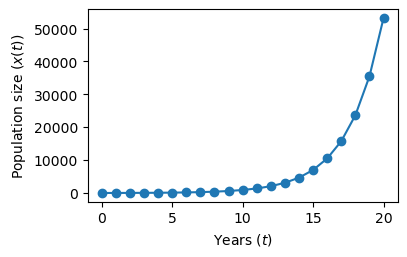

In [4]:
def simple_growth(r, x):
    return r * x

r = 1.5              # Each year x is increased by 50%
x = [16]             # Initial number of individuals
for _ in range(20):
    x.append(simple_growth(r, x[-1])) 

fig = plt.figure(figsize=(4, 2.5))
plt.plot(x, 'o-')
plt.xlabel('Years ($t$)')
plt.ylabel('Population size ($x(t)$)')
plt.show()

- The Logistic Map prevents unlimited growth by inhibiting growth whenever it achieves a high level. 
- This is achieved by introducing an additional term $[1 - x(t)]$.
- The growth measure $x$ is also rescaled so that the maximum value $x$ can achieve is 1. 
- So if the maximum size is 8 billions, $x$ is the proportion of that maximum.

- The new growth model is 

$$x(t+1) = r x(t)[1 - x(t)]$$

- with $r \in [0,4]$.
- The $[1-x(t)]$ inhibits the growth because as $x$ approaches 1 (the maximum), $[1-x(t)]$ approaches 0.

In [5]:
def logistic(r, x):
    return r * x * (1 - x)

- Plotting $x(t)$ against $x(t+1)$ shows the nonlinearity of the system.

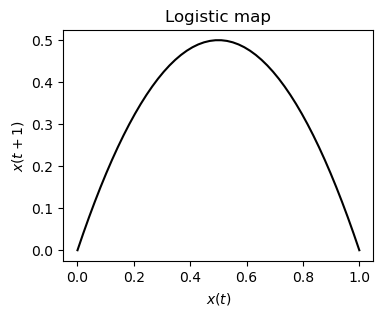

In [6]:
x = np.linspace(0, 1)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(x, logistic(r=2, x=x), 'k')
ax.set_title('Logistic map')
ax.set_xlabel('$x(t)$')
ax.set_ylabel('$x(t+1)$')
plt.show()

- To see how it beahaves, we iterate the function and plot the growth.
- It turns out that the logistic map changes drastically its behavior depending the the value of the parameter $r$. 
- To see this, we examine the time series of the system's state as $r$ changes from 0 to 1.

In [7]:
def plot_time_series(r, x0, n, color, ax=None):
    t = np.arange(n)
    x = np.empty(n)
    x[0] = x0
    for i in range(1, n):
        x[i] = logistic(r, x[i-1])
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(t, x, 'o-', color=color, alpha=0.5, label=f'$r = {r:.2f}, x(0) = {x0}$')
    ax.set_xlabel('Time step ($t$)')
    ax.set_ylabel('Population size ($x(t)$)')
    ax.legend()

In [8]:
def plot_system(r, x0, n, ax=None):
    # Plot the function and the y=x diagonal line.
    t = np.linspace(0, 1)
    ax.plot(t, logistic(r, t), 'k', lw=2)
    ax.plot([0, 1], [0, 1], 'gray', linestyle='--', lw=2)

    # Recursively apply y=f(x) and plot two lines:
    # (x, x) -> (x, y)
    # (x, y) -> (y, y)
    x = x0
    for _ in range(n):
        y = logistic(r, x)
        # Plot the two lines.
        ax.plot([x, x], [x, y], 'gray', lw=1, alpha=0.5)
        ax.plot([x, y], [y, y], 'gray', lw=1, alpha=0.5)
        # Plot the positions with increasing
        ax.plot([x], [y], 'o', color='tab:blue', ms=10, alpha=0.3)
        x = y

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('$x(t-1)$')
    ax.set_ylabel('$x(t)$')
    ax.set_title(f"$r={r:.2f}, \, x(0)={x0:.1f}$")

#### Regime $r < 1$

- So long as $r$ is less than 1, the state of the system $x$ will go toward 0. 
- This is called *one-point attractor*.

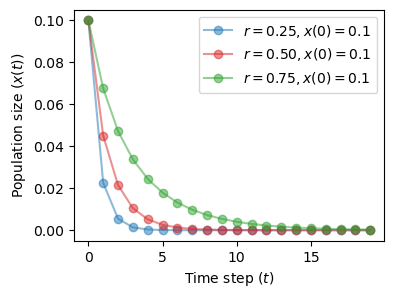

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_time_series(r=0.25, x0=0.1, n=20, color='tab:blue', ax=ax)
plot_time_series(r=0.5, x0=0.1, n=20, color='tab:red', ax=ax)
plot_time_series(r=0.75, x0=0.1, n=20, color='tab:green', ax=ax)

- The situation does not change for different values of the initial condition $x(0)$.
- The initial state is quickly forgotten and the system ends in the same attractor.

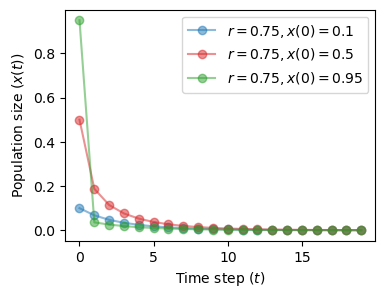

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_time_series(r=0.75, x0=0.1, n=20, color='tab:blue', ax=ax)
plot_time_series(r=0.75, x0=0.5, n=20, color='tab:red', ax=ax)
plot_time_series(r=0.75, x0=0.95, n=20, color='tab:green', ax=ax)

- We can also see how the current state $x(t)$ relates to the previous state $x(t-1)$.

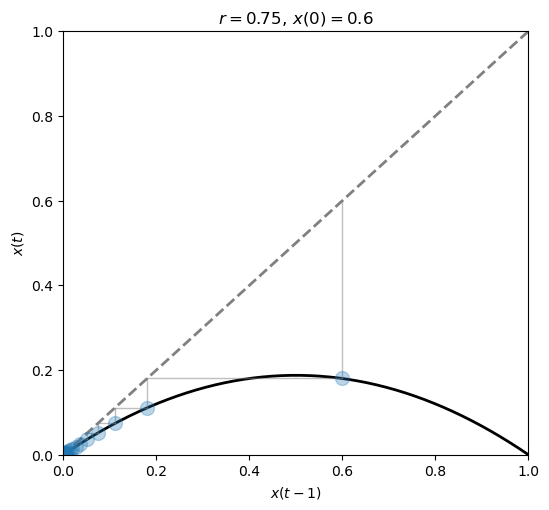

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))
plot_system(r=0.75, x0=.6, n=20, ax=ax)

#### Regime $1 < r < 3$

- We still have a one-point attractor, but now it changes with the value of $r$.

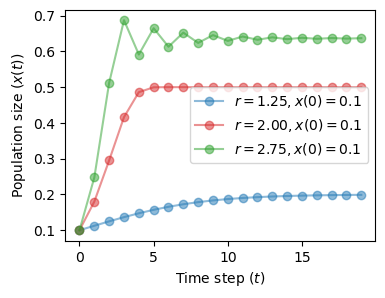

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_time_series(r=1.25, x0=0.1, n=20, color='tab:blue', ax=ax)
plot_time_series(r=2.0, x0=0.1, n=20, color='tab:red', ax=ax)
plot_time_series(r=2.75, x0=0.1, n=20, color='tab:green', ax=ax)

- As before, the initial state is inconsequential and its effect is washed-out eventually.

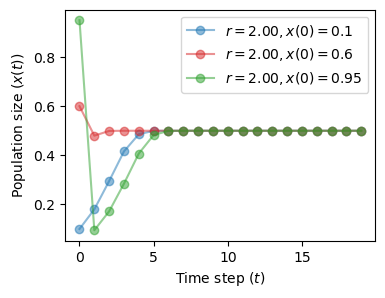

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_time_series(r=2.0, x0=0.1, n=20, color='tab:blue', ax=ax)
plot_time_series(r=2.0, x0=0.6, n=20, color='tab:red', ax=ax)
plot_time_series(r=2.0, x0=0.95, n=20, color='tab:green', ax=ax)

- As we get closer to $r=3$ the state oscillates more and more before settling down to its attractor.
- The behavior is best observed by looking at the state-vs-state plot.

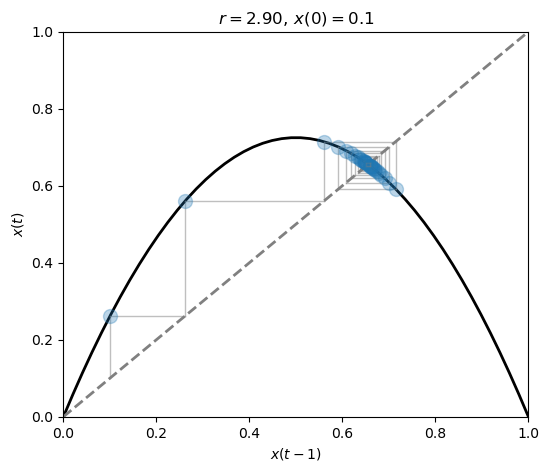

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_system(r=2.9, x0=.1, n=30, ax=ax)

#### Regime $r > 3$

- As soon as we move beyond $r=3$ the system starts oscillating between two points. 
- We have a two-point attractor. 
- The phenomenon we observe is called *bifurcation*, or *period-doubling*.

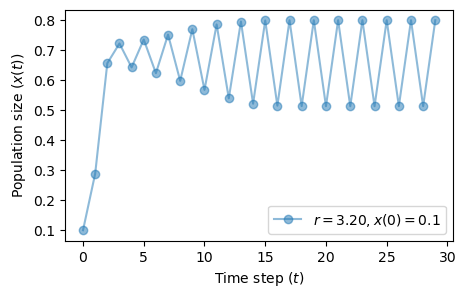

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_time_series(r=3.2, x0=0.1, n=30, color='tab:blue', ax=ax)

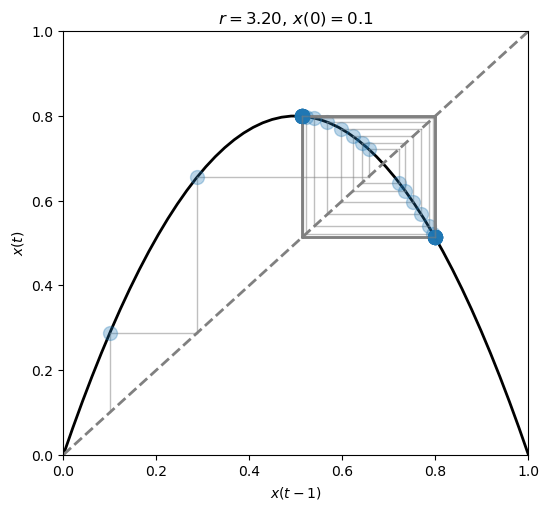

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))
plot_system(r=3.2, x0=.1, n=60, ax=ax)

- At $r=3.54$ another bifurcation occurs.
- We have now reached a 4-point attractor.

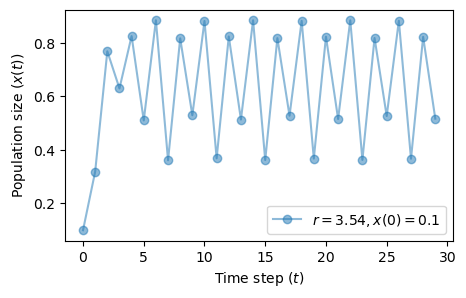

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_time_series(r=3.54, x0=0.1, n=30, color='tab:blue', ax=ax)

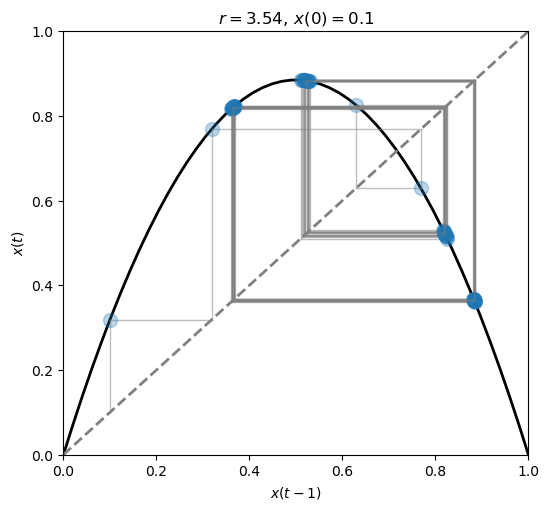

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))
plot_system(r=3.54, x0=.1, n=60, ax=ax)

- The number of bifurcations keep growing as we increase $r$.
- Eventually, we witstand the so-called *N-point attractor*.
- The system settles down to an attractor that looks "unstable" or "strange".
- This a characterizing property of *chaotic systems*.

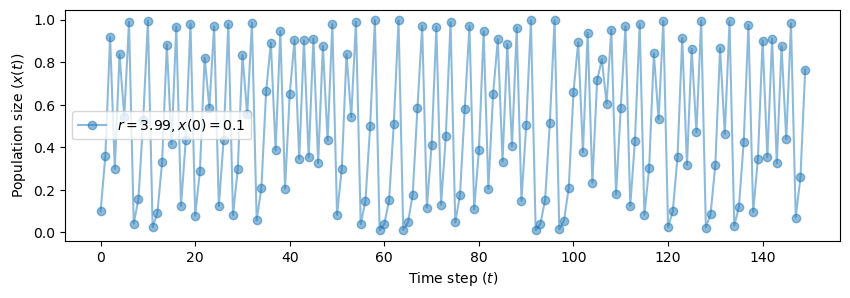

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_time_series(r=3.99, x0=0.1, n=150, color='tab:blue', ax=ax)

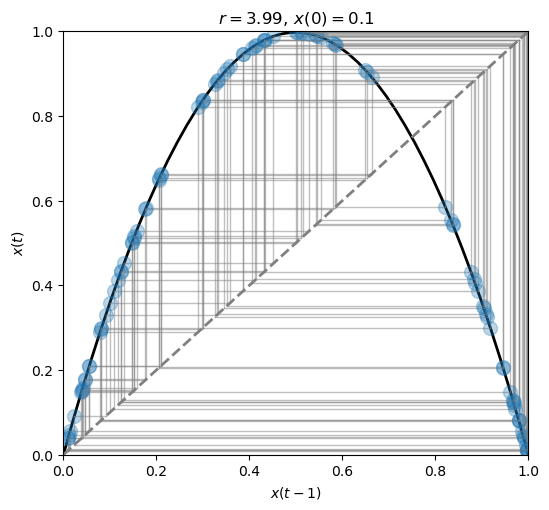

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5.5))
plot_system(r=3.99, x0=.1, n=100, ax=ax)

### Bifurcation diagrams

- As we said, a bifucation is a period-doubling, i.e., a change from an $N$-point attractor to a $2N$-point attractor.
- In the Logistic map, it occurs when the control parameter ($r$) is changed.
- A *bifurcation diagram* is a visual summary of the succession of period-doubling produced as the control parameter changes. 

- Let's compute the bifurcation diagram of the logistic map.
- On the x-axis, we have the value of $r$. 
- On the y-axis, we have the distinct points the system settles down to.

In [21]:
def bifuracion_diagram(r, ax, iterations=1000, last=100):
    x = 1e-5 * np.ones_like(r)
    for i in range(iterations):
        x = logistic(r, x)
        if i >= (iterations - last): # plot only the 'last' last iterations
            ax.plot(r, x, ',k', alpha=.25)
    ax.set_title("Bifurcation diagram")
    ax.set_xlabel("$r$")
    ax.set_ylabel("$x$")

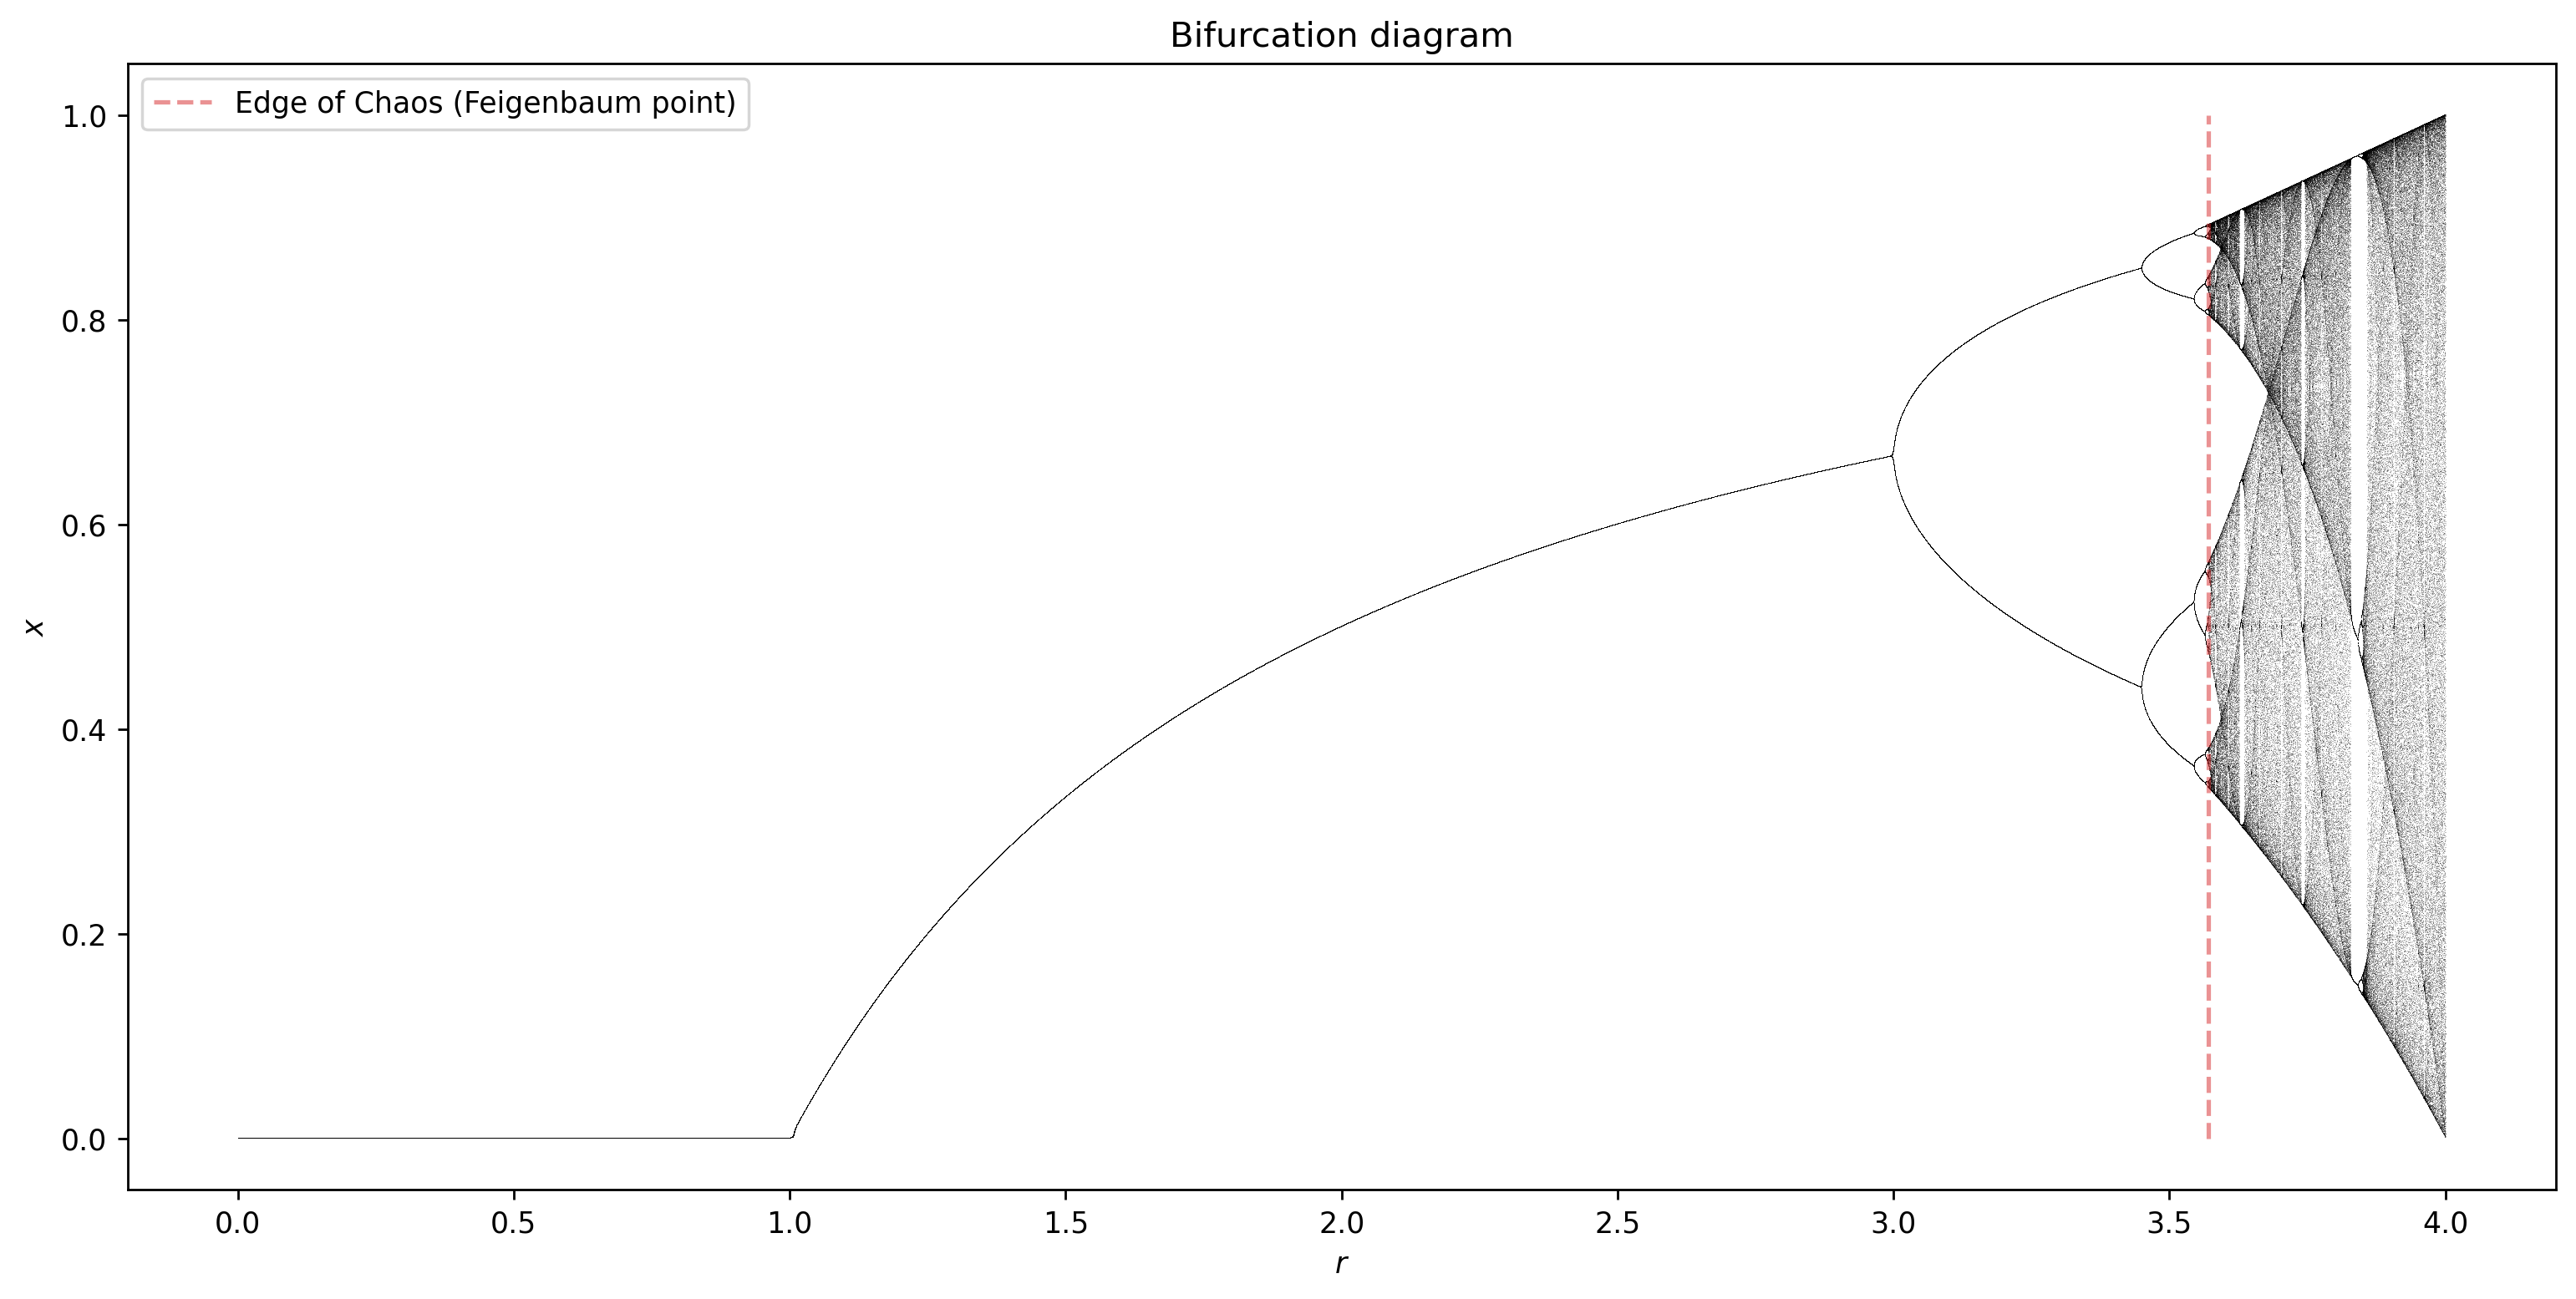

In [22]:
r = np.linspace(0, 4.0, 30000)

fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=250)
bifuracion_diagram(r, ax)
ax.vlines(3.569945, 0, 1, 'tab:red', linestyles='--', alpha=0.5, label='Edge of Chaos (Feigenbaum point)')
plt.legend()
plt.show()

- We see that for $r<1$, zero is the one point attractor. 
- For $1<r<3$ we still have one-point attractors, but the 'attracted' value of $x$ increases as $r$ increases. 
- Bifurcations occur at $r=3$, $r=3.45$, $3.54$, $3.564$, $3.569$, etc...
- Approximately at $r=3.57$ our system become chaotic.
- However, the system is not chaotic for all values of $r$ greater than 3.57.

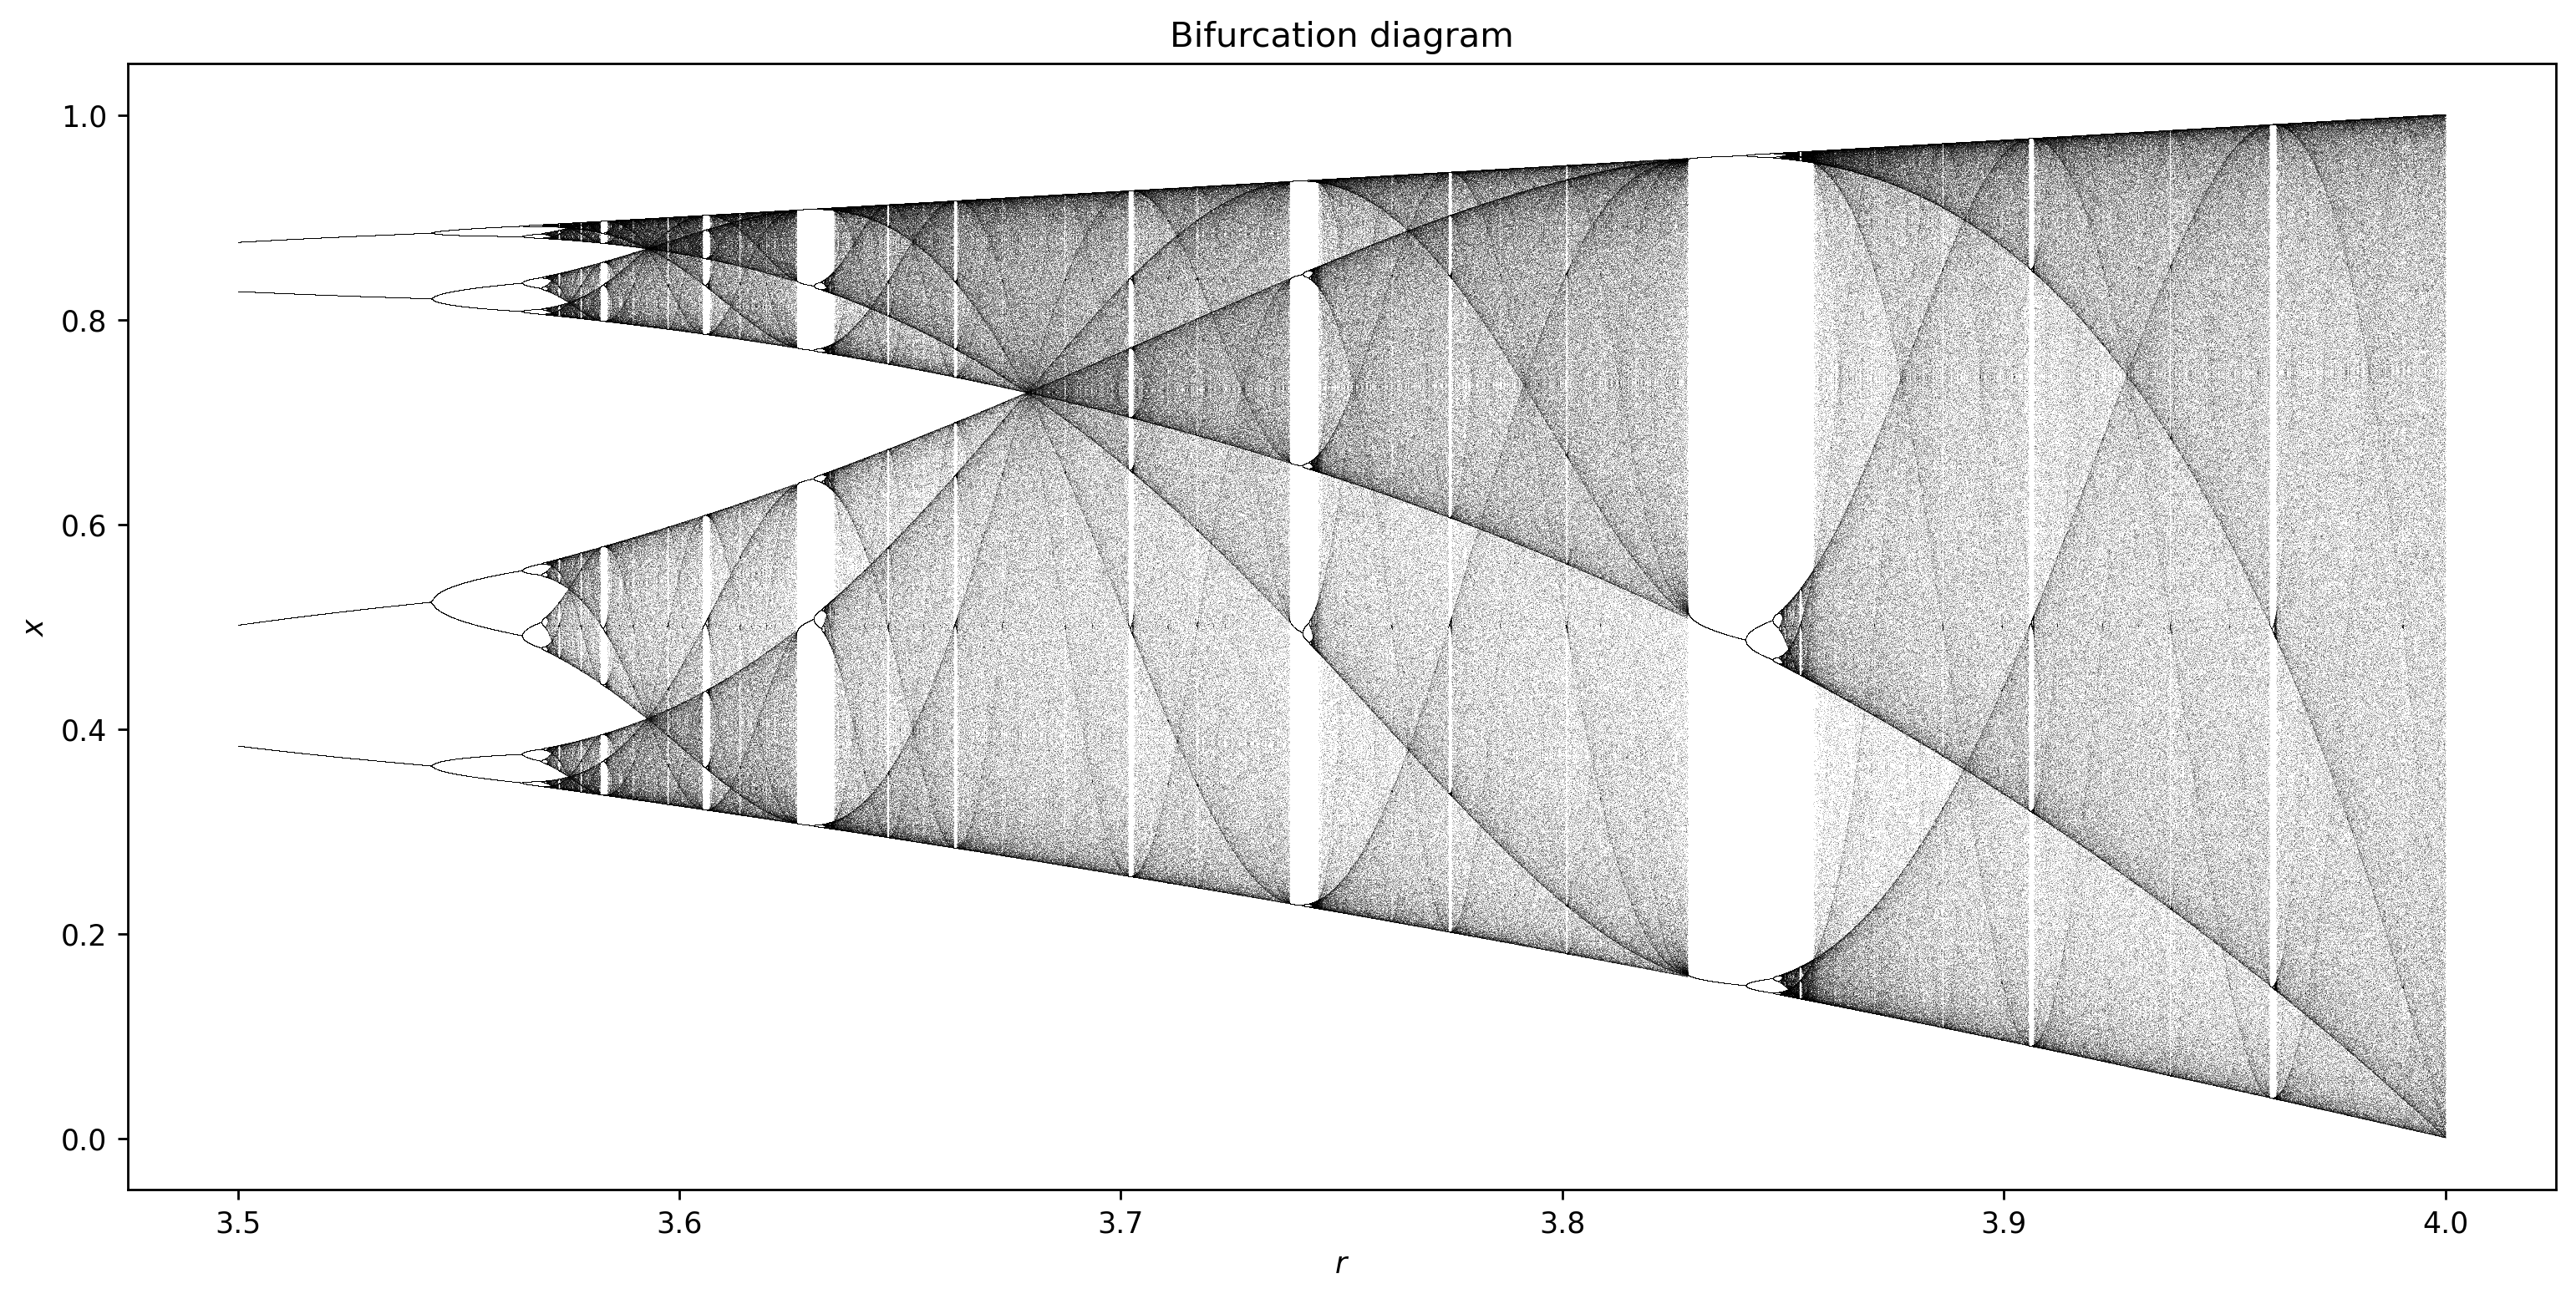

In [23]:
n = 30000 # number of values of r
r = np.linspace(3.5, 4.0, n)

fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=250)
bifuracion_diagram(r, ax)
plt.show()

- At several values of $r > 3.57$ there are regions where a small number of $x$-values are visited. 
- These regions produce the white spaces in the diagram.
- For example, at $r=3.83$ there is a three-point attractor.
- Between 3.57 and 4 there is a rich interleaving of chaos and order. 
- A small change in $r$ can make a stable system chaotic, and vice-versa.

---

## Chaotic systems

- Many real-world phenomena are chaotic, particularly those that involve nonlinear interactions among many agents (complex systems). 
- Examples can be found in meteorology, economics, biology, and other disciplines.
- In the following, we will explore some famous chaotic systems and their properties.

### Sensitivity to initial conditions

- A characterizing feature of chaotic systems is their sensitivity to initial conditions.
- Let's see it with the Logistic map for $r=3.99$.
- We will start from two very close initial conditions: $x(0)=0.1$ and $x(0)=0.101$.

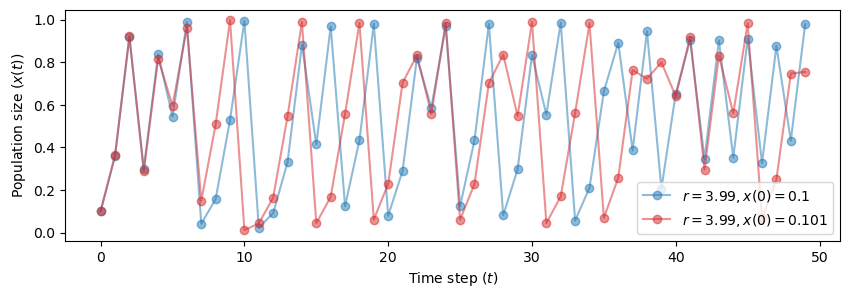

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_time_series(r=3.99, x0=0.1, n=50, color='tab:blue', ax=ax)
plot_time_series(r=3.99, x0=0.101, n=50, color='tab:red', ax=ax)

- It takes very few steps for the two trajectories to diverge.
- What if we take the initial conditions *really* close?

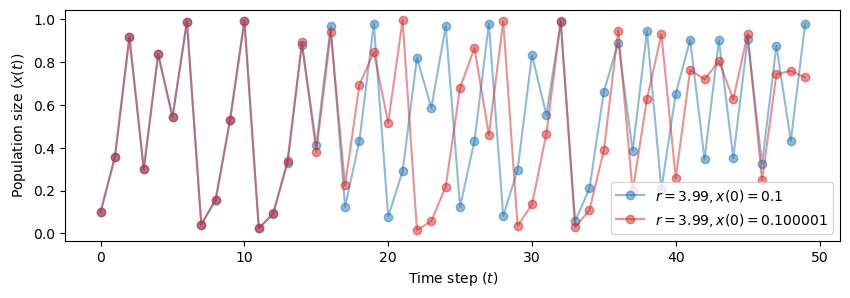

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_time_series(r=3.99, x0=0.1, n=50, color='tab:blue', ax=ax)
plot_time_series(r=3.99, x0=0.100001, n=50, color='tab:red', ax=ax)

- The example should make this point clear:
> In a chaotic systrem no matter how close the initial conditions are, if they are different the trajectories will eventually diverge.
- From another perspective, the system will *never forget* its initial state.

### Detecting chaos

- How do we determine if a system has a contractive or chaotic dynamics?
- We have several tools.
- One is to measure the sensitivity to initial conditions, which we know being high for chaotic system.
- The *Lyapunov exponent* can be used to measure this.

#### Lyapunov exponent

- The Lyapunov exponent quantifies the rate at which nearby trajectories in the system diverge or converge over time. 
- It tells us how sensitive a system is to its initial conditions, a property often associated with chaotic behavior. 
- There are actually several Lyapunov exponents for a given system, corresponding to different directions in the system's phase space.
- The *largest* Lyapunov exponent is most commonly used to detect chaos.
- A system is considered chaotic if it has at least one *positive* Lyapunov exponent. 

**Definition** 

- Let a dynamical system be defined as 

$$\dot{x} = f(x, t)$$ 

- where:
    - $\dot{x}$ represents the time derivative of $x$,
    - $f(x, t)$ is the function defining the system's evolution over time.

- Consider two nearby points in the system's phase space  $x_0$ and $x_0 + \delta x_0$, where $\delta x_0$ is a small perturbation.
- Their trajectories diverge over time according to 

$$\delta x(t) \approx \delta x_0 e^{\lambda t}$$ 

- where:
    - $\delta x(t)$ is the separation between the two trajectories at time $t$,
    - $\lambda$ is the Lyapunov exponent.

- The exponent is calculated as 

$$\lambda = \lim_{t \to \infty} \lim_{|\delta x_0| \to 0} \frac{1}{t} \ln \left( \frac{|\delta x(t)|}{|\delta x_0|} \right)$$

- This limit, if it exists, gives the average rate of exponential divergence (if $\lambda > 0$) or convergence (if $\lambda < 0$) of trajectories starting from infinitesimally close initial conditions. 
- The exponent can often be computed analytically.
- Otherwise, it is computed numerically by observing how small perturbations evolve over time.

- A positive Lyapunov exponent implies that small differences in initial conditions lead to exponential divergence of trajectories.
- This makes long-term predictions very difficult despite the system being deterministic. 
- This sensitivity to initial conditions is often referred to as the *butterfly effect* in the context of chaos theory.

- Next, we make a function to plot the Lyapunov exponent in the logistic map as we increase $r$.
- We will color in red values of $r$ associated with $\lambda>0$, which indicates that the system has a chaotic behavior.
- To check if the Lyapunov exponent works as a chaos detector, we will compare it with the bifurcation map.

In [26]:
def lyapunov(r, ax, iterations=1000):
    x = 1e-5 * np.ones_like(r)  
    lyapunov = np.zeros_like(r)
    for i in range(iterations):
        x = logistic(r, x)
        lyapunov += np.log(abs(r - 2 * r * x)) # Partial sum of the Lyapunov exponent.
    
    ax.axhline(0, color='k', lw=.5, alpha=.5)
    
    # Negative Lyapunov exponent.
    ax.plot(r[lyapunov < 0],
            lyapunov[lyapunov < 0] / iterations,
            '.k', alpha=.5, ms=.5)
    
    # Positive Lyapunov exponent.
    ax.plot(r[lyapunov >= 0],
            lyapunov[lyapunov >= 0] / iterations,
            '.', color='tab:red', alpha=.5, ms=.5)
    ax.set_ylim(-2, 1)
    ax.set_title("Lyapunov exponent")

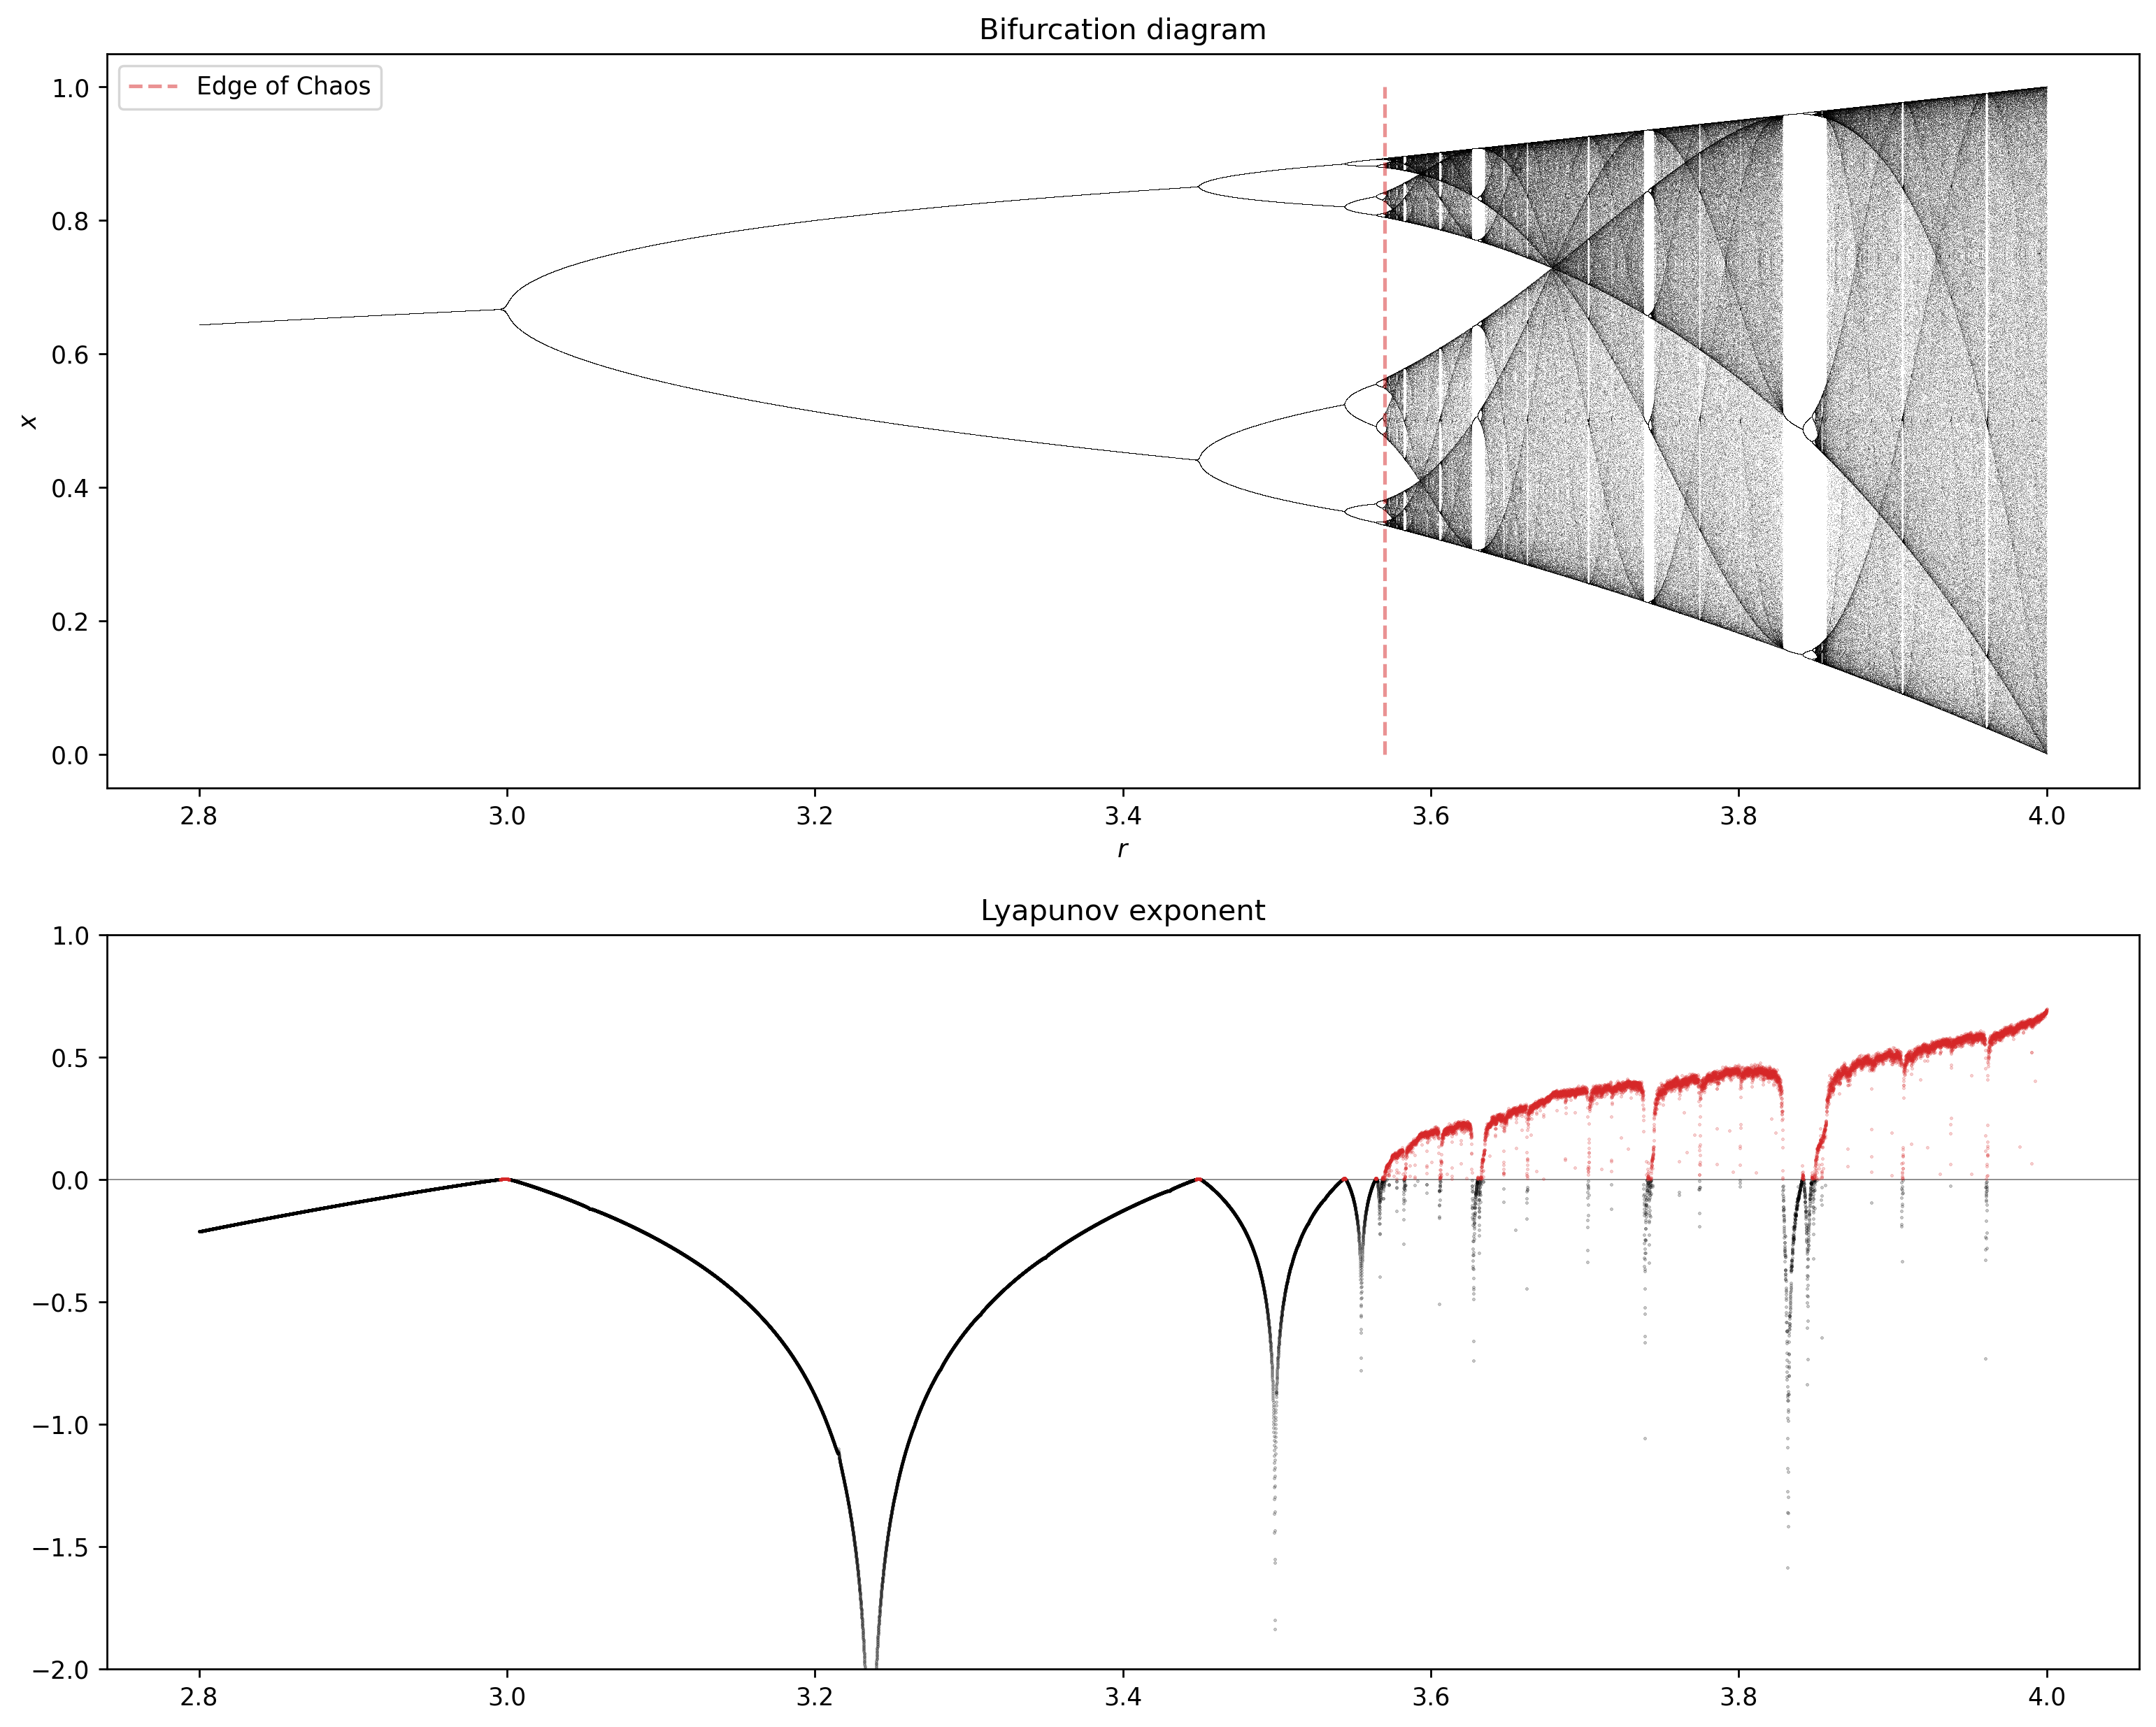

In [27]:
r = np.linspace(2.8, 4.0, 30000)

fig, axes = plt.subplots(2, 1, figsize=(15, 12), dpi=250)
bifuracion_diagram(r, axes[0])
axes[0].vlines(3.569945, 0, 1, 'tab:red', linestyles='--', alpha=0.5, label='Edge of Chaos')
axes[0].legend()
lyapunov(r, axes[1])
plt.show()

#### Return maps

- Another important distinction is between chaos and randomness.
- At first glance, a chaotic and a stochastic processes look a lot alike.
- Let's consider the time series of samples generated by:
    - a uniform distribution,
    - a normal distribution,
    - the Logistic map for $r=3.99$.

In [28]:
uniform_data = np.random.uniform(low=0, high=1, size=300) # Random uniform

normal_data = np.random.randn(300) # Random normal

lgt_data = np.empty(300) # Logistic map
lgt_data[0] = 0.1
for i in range(1, len(lgt_data)):
    lgt_data[i] = logistic(3.99, lgt_data[i-1])

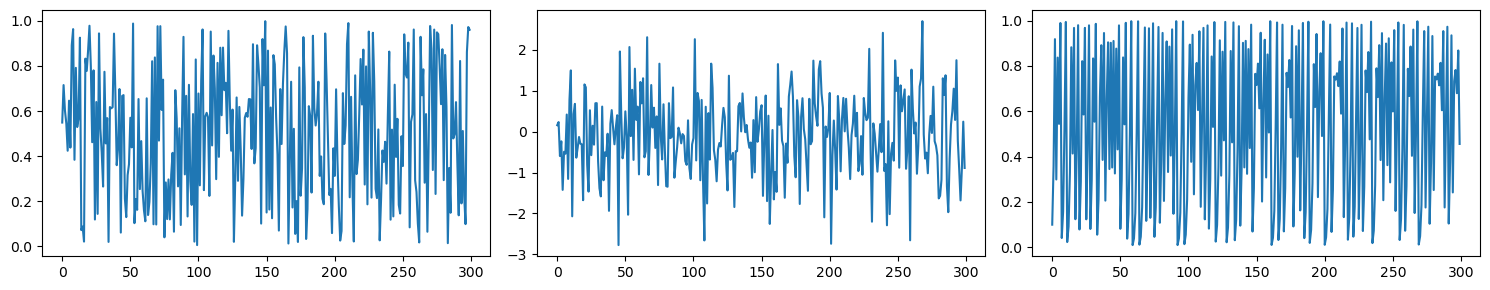

In [29]:
fig, axes = plt.subplots(1,3,figsize=(15, 3))
axes[0].plot(uniform_data)
axes[1].plot(normal_data)
axes[2].plot(lgt_data)
plt.tight_layout()
plt.show()

- How do we determine if a system is chaotic or random?
- Also in this case we have several tools at our disposal.
- One of this is the *return map*.

- We saw the return map already before.
- It simply consists in plotting the current value $x(t)$ against the next one $x(t+1)$.
- If the time series is random, we will see no or little structure as the next value is uncorrelated with the current one.
- Instead, if the time series is chaotic we will see a well-defined structure.

In [30]:
def return_map(series, ax, title):
    ax.plot(series[:-1], series[1:], 'o', alpha=0.2)
    ax.set_xlabel('$x(t)$')
    ax.set_ylabel('$x(t+1)$')
    ax.set_title(title)

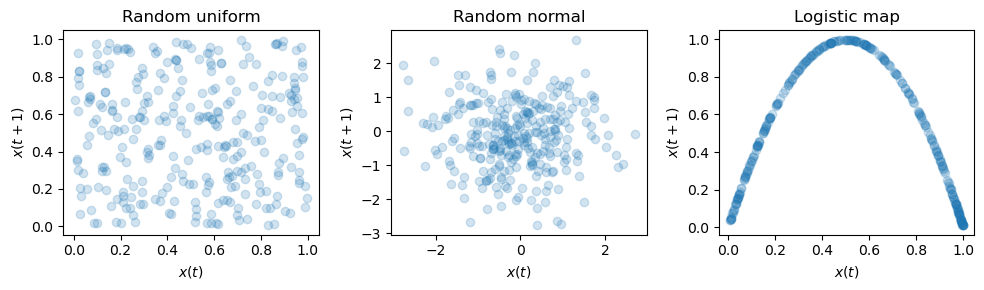

In [31]:
fig, axes = plt.subplots(1,3,figsize=(10, 3))
return_map(uniform_data, axes[0], "Random uniform")
return_map(normal_data, axes[1], "Random normal")
return_map(lgt_data, axes[2], "Logistic map")
plt.tight_layout()
plt.show()

---

## Higher-dimensional continous-time systems

- In the case of the Logistic map the system had only one variable: $x(t)$.
- In general, we can have systems with two or more variables.
- The number of variables defines the *dimensionality* of the system.
- The *state* of a system is the current values of its variables.

- Most of the time series we saw originated from *discrete-time* systems that evolve at specific intervals in time. 
- The time variable $t$ takes values from a discrete set, often integers, indicating distinct time steps or periods.
- The dynamics of discrete-time systems are described using *difference equations*, e.g., 

$$x(t+1) = f(x(t))$$

- Discrete-time systems are common in digital signal processing, computer algorithms, economic models, and any context where observations or changes occur at well-defined intervals.

- In *continuous-time* systems, the time variable $t$ can take any value in a range of real numbers. 
- This means that the system's state can change at any instant in time.
- The dynamics of continuous-time systems are described using *differential equations* that model how the state variables change with respect to continuous time, e.g., 

$$\frac{dx}{dt} = f(x)$$

- Many physical and natural processes are modeled as continuous-time systems, such as the motion of planets, electrical circuits, and fluid dynamics.

### 2D - Lotka-Volterra equations

- The Lotka-Volterra equations are used to model the predator-prey population system.
- It extends the logistic map by modeling the interactions between two species: a predator and its prey. 
- The growth of the two species is affected by the presence of the other speciemen.
- The Logistic map is a discrete-time, univariate model represented by a single equation.
- The predator-prey model is a continuous-time, bivariate system.

The Lotka-Volterra equations for predator-prey dynamics are given by:

\begin{align*}
\frac{dx}{dt} &= \alpha x - \beta xy \\
\frac{dy}{dt} &= \delta xy - \gamma y
\end{align*}

- $x$ and $y$ are the prey and predator populations, respectively,
- $\frac{dx}{dt}$ and $\frac{dy}{dt}$ are the rate of change of the prey and predator populations over time, respectively,
- $\alpha$ is the natural growth rate of prey in the absence of predators,
- $\beta$ is the death rate of prey due to predation,
- $\delta$ is the efficiency of converting consumed prey into predator offspring,
- $\gamma$ is the natural death rate of predators in the absence of food (prey).

- This system can exhibit a variety of dynamics, including stable limit cycles, where the populations of predators and prey oscillate in a regular, periodic fashion. 
- The attractor in the Lotka-Volterra system, in this case, is typically a closed loop, reflecting the cyclic nature of the predator-prey interactions.

<img src="media/lokta_volt.png" style="width: 50%; display: block; margin: auto;">

- Let's define the system of differential equations.
- To "run" the system, we use a numerical solver `scipy.integrate.solve_ivp`.
- Since the solver takes a single state variable, we define `z = [x, y]`.
- Note that the variable `t` is not used in the function we define, but is necessary to the solver.

In [32]:
# Lotka-Volterra equations
def lotka_volterra(t, z, alpha, beta, delta, gamma):
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

- For the next plots we will use a function `lokta_volterra_attractor` that:
    - Runs the solver computing the sequence of states over time.
    - Plots the time series of the state variables.
    - Plots the attractor.
- Note the syntax of `solve_ivp`: all the parameters of the systems are passed through `args` argument. More info [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

In [33]:
def lokta_volterra_attractor(z0, t, 
                             alpha=2, beta=1.25, gamma=1.5, delta=0.75,
                             ax1=None, ax2=None):

    # Solve the differential equations
    sol = solve_ivp(lotka_volterra, [t.min(), t.max()], z0, 
        args=(alpha, beta, delta, gamma), t_eval=t)

    if ax1 is not None:
        # Plot the time series
        ax1.plot(sol.t, sol.y[0], label='Prey $x(t)$')
        ax1.plot(sol.t, sol.y[1], label='Predator $y(t)$')
        ax1.set_title('System variables')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Population')
        ax1.legend()

    if ax2 is not None:
        # Plot attractor
        ax2.plot(sol.y[0], sol.y[1], label=f'$z(0) = {z0}$', alpha=0.5, linewidth=0.3)
        ax2.set_title('Attractor')
        ax2.set_xlabel('Prey Population')
        ax2.set_ylabel('Predator Population')
        ax2.legend()

- For the given set of parameters, the system shows a chaotic behavior.

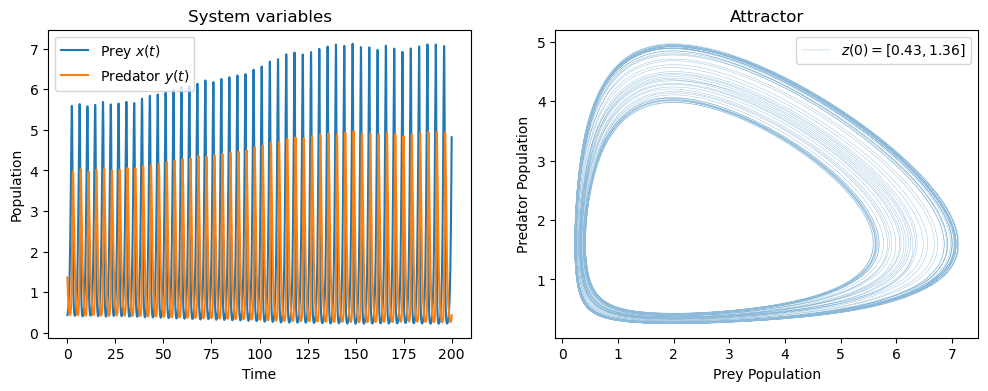

In [34]:
t = np.linspace(0, 200, 10000)
_, axes = plt.subplots(1, 2, figsize=(12,4))
z0 = [0.43, 1.36]
lokta_volterra_attractor(z0, t, ax1=axes[0], ax2=axes[1])

- The system in this configuration is very sensitive to different initial conditions.

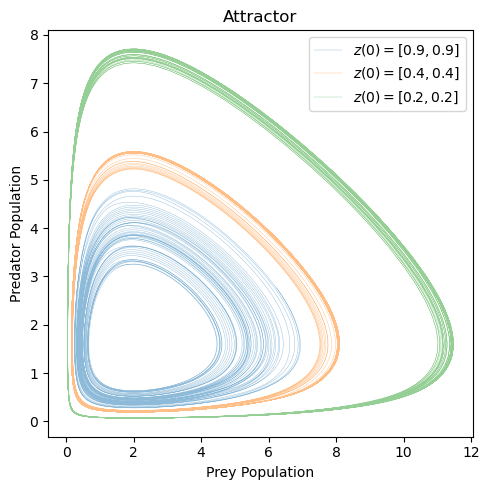

In [35]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

z0 = [0.9, 0.9]
lokta_volterra_attractor(z0, t, ax2=ax)
z0 = [0.4, 0.4]
lokta_volterra_attractor(z0, t, ax2=ax)
z0 = [0.2, 0.2]
lokta_volterra_attractor(z0, t, ax2=ax)

plt.tight_layout()
plt.show()

### Rössler system

- The Rössler system is notable for its chaotic behavior, which emerges from a simple set of non-linear ordinary differential equations (ODEs).

\begin{align*}
\frac{dx}{dt} &= -y - z, \\
\frac{dy}{dt} &= x + ay, \\
\frac{dz}{dt} &= b + z(x - c),
\end{align*}

- $x$, $y$, and $z$ are the system states over time $t$, and $a$, $b$, and $c$ are parameters that determine the system's behavior. 

- Typical values that lead to chaotic behavior are $a = 0.2$, $b = 0.2$, and $c = 5.7$, though chaos can be observed for other values as well.

In [36]:
# Define the Rössler attractor system of equations
def rossler_system(t, y, a, b, c):
    x, y, z = y
    dxdt = -y - z
    dydt = x + a*y
    dzdt = b + z*(x - c)
    return [dxdt, dydt, dzdt]

In [37]:
# Parameters
a, b, c = 0.2, 0.2, 5.7
y0 = [0.0, 2.0, 0.0]  # Initial conditions
T = 500 # Final time
t_span = [0, T]  # Time span for the integration

# Solve the differential equations
solution = solve_ivp(rossler_system, t_span, y0, args=(a, b, c), dense_output=True)
t = np.linspace(0, T, int(5e4))
ross_sol = solution.sol(t)

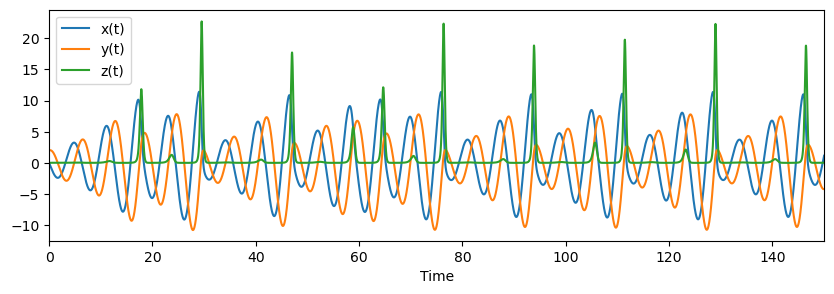

In [38]:
# Plot time series
fig, ax = plt.subplots(1,1,figsize=(10, 3)  )
ax.plot(t, ross_sol[0], label="x(t)")
ax.plot(t, ross_sol[1], label="y(t)")
ax.plot(t, ross_sol[2], label="z(t)")
ax.set_xlabel("Time")
ax.set_xlim(0, 150)
plt.legend()
plt.show()

In [39]:
def plot_attractor(data, title="", interactive=False):
    xt, yt, zt = data[0], data[1], data[2]
    if interactive:
        fig = go.Figure(data=[go.Scatter3d(x=xt, y=yt, z=zt, mode='lines', line=dict(color='black', width=1))])
        fig.update_layout(title=title, scene=dict(xaxis_title='x(t)', yaxis_title='y(t)', zaxis_title='z(t)'),
                          autosize=False, width=800, height=600, margin=dict(l=0, r=0, b=0, t=0))
        fig.show()
    else:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(xt, yt, zt, linewidth=0.2, alpha=0.7, color='k')
        ax.set_title(title)
        plt.show()

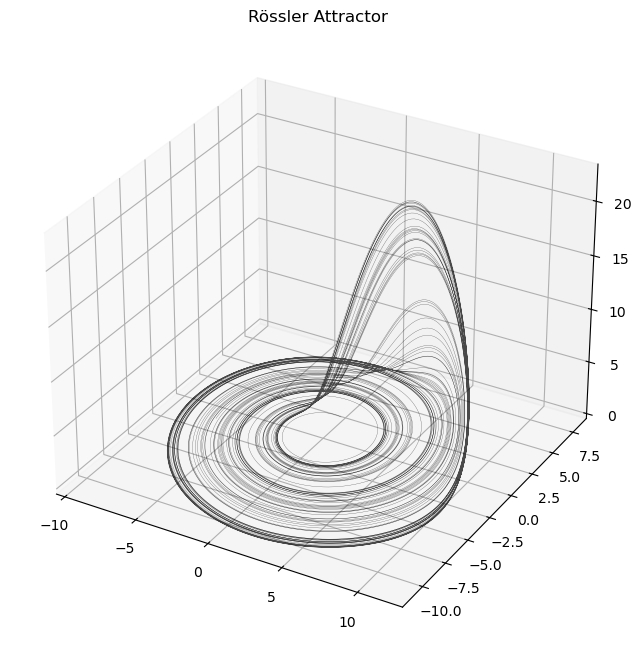

In [40]:
# Plot the Rössler attractor
plot_attractor(ross_sol, title="Rössler Attractor", interactive=False)

### Lorenz system

<img src="media/lorenz.gif" style="width: 70%; display: block; margin: auto;">


- The Lorenz system was one of the first examples to demonstrate the phenomenon of deterministic chaos.
- Like the other chaotic systems, this one exhibits sensitive dependence on initial conditions.
- Also, it generates apparently random and unpredictable patterns, despite being governed by deterministic laws. 

- The study of the Lorenz system had profound implications across numerous fields, from meteorology and climate science to engineering, and economics. 
- It challenged previous notions of predictability in physical systems and contributed to the development of chaos theory by:
  - deepening the understanding of complex systems,
  - highlighting the limitations of current prediction models in systems with chaotic dynamics,
  - inspiring new approaches in the analysis and control of such systems.

The Lorenz system is defined by the following set of non-linear ODEs:

\begin{align*}
\frac{dx}{dt} &= \sigma(y - x), \\
\frac{dy}{dt} &= x(\rho - z) - y, \\
\frac{dz}{dt} &= xy - \beta z,
\end{align*}

Typical values at which the Lorenz system shows a chaotic behavior are $\sigma = 10$, $\rho = 28$, and $\beta = \frac{8}{3}$.

### Lyapunov exponents in higher dimensional continuous systems

- Previously, we introduced the largest [Lyapunov exponent](#lyapunov-exponent) $\lambda$ as a tool for detecting chaos.
- For the Logistic map, we showed that when $\lambda > 0$ the dyanmic of the system is chaotic.

- In higher dimensional continuous systems, the analysis of Lyapunov exponents remains a crucial method for understanding the system's dynamics.
- In particular, they can still be used to determine stability and the onset of chaos.
- However, in this setting things become more complicated.

- In one-dimensional discrete systems like the Logistic map, there is one Lyapunov exponent.
- Instead, in a continuous system of dimension $n$, there are $n$ Lyapunov exponents.
- Calculating these exponents involves complex numerical methods, which are computationally expensive and sensitive to numerical precision.
- Additionally, the initial conditions and parameter values have a stronger influence on the Lyapunov spectrum.

- *Positive exponents* indicate directions in which the system exhibits sensitive dependence on initial conditions, a characteristic of chaotic dynamics.
- *Zero exponents* suggest neutral stability along certain directions, often associated with conserved quantities or symmetries in the system.
- *Negative exponents* reflect directions of convergence, indicating stability in those dimensions.

- The largest Lyapunov exponent is still the most important in predicting the overall system behavior, particularly chaos.
- However, the entire spectrum can provide insights into more complex dynamics like:
    - mixed modes (simultaneous stable and chaotic behaviors),
    - hyperchaotic systems (systems with more than one positive Lyapunov exponent).

- To compute the Lyapunov spectrum we use the function `computeLE(func, func_jac, x0, t, p)`, which is part of the companion code to this course.
- The arguments of the function are:
    - `func`, which specifies the differential equations of the dynamical system,
    - `func_jac`, which is the Jacobian of the system, i.e., the partial derivatives,
    - `x0`, which represents the initial conditions,
    - `t`, the time vector specifying the time steps along which the trajectory of the system is computed,
    - `p`, the parameters of the system.

- For the Lorenz system, `func` is defined as follows

In [41]:
def lorenz(t, x, sigma, rho, beta):
    res = np.zeros_like(x)
    res[0] = sigma*(x[1] - x[0])
    res[1] = x[0]*(rho - x[2]) - x[1]
    res[2] = x[0]*x[1] - beta*x[2]
    return res

- The Jacobian of the system is the matrix of the partial derivatives.
- Consider a general dynamical system with 3 variables $x$, $y$, and $z$, represented by the equations:

$$
\begin{cases}
\dot{x} = f(x, y, z) \\
\dot{y} = g(x, y, z) \\
\dot{z} = h(x, y, z)
\end{cases}
$$

- The Jacobian is:

$$
J = \begin{bmatrix}
\frac{\partial f}{\partial x} & \frac{\partial f}{\partial y} & \frac{\partial f}{\partial z} \\
\frac{\partial g}{\partial x} & \frac{\partial g}{\partial y} & \frac{\partial g}{\partial z} \\
\frac{\partial h}{\partial x} & \frac{\partial h}{\partial y} & \frac{\partial h}{\partial z}
\end{bmatrix}
$$

- So, for the Lorenz system we have:

$$
J_{\text{Lorenz}} = \begin{bmatrix}
-\sigma & \sigma & 0 \\
\rho - z & -1 & -x \\
y & x & -\beta
\end{bmatrix}
$$

In [42]:
def lorenz_jac(t, x,  sigma, rho, beta):
    res = np.zeros((x.shape[0], x.shape[0]))
    res[0,0], res[0,1] = -sigma, sigma
    res[1,0], res[1,1], res[1,2] = rho - x[2], -1., -x[0]
    res[2,0], res[2,1], res[2,2] = x[1], x[0], -beta
    return res

- Finally, we specify the initial conditions `x0`, the time vector `t`, and the system's parameters `p`.
- The latter, in the case of Lorenz systems are $\sigma$, $\rho$, and $\beta$.

In [43]:
x0 = np.array([1.5, -1.5, 20.]) 
t = np.arange(0, 1000, 1e-2)
sigma, rho, beta = 10., 28., 8/3
p = (sigma, rho, beta)

LEs, hist = computeLE(lorenz, lorenz_jac, x0, t, p=p)
print(f"Lyapunov Exponents: {LEs}")

Lyapunov Exponents: [ 9.06320944e-01 -2.38039941e-03 -1.45705049e+01]


- One of the Lyapunov exponents is positive.
- This suggests that the Lorenz system configured with the specific values of $\sigma$, $\rho$, and $\beta$ exibits a chaotic behavior along one direction.

### Bifurcation diagrams in higher dimensional continuous systems

- When studying the Logistic map we introduced the [bifurcation diagram](#bifurcation-diagrams), which is the succession of period-doubling produced as the control parameter changes.
- We can compute bifurcation diagrams also for higher dimensional continuous systems.
- Compared to unidimensional discrete systems there are two important differences.

1. Since we have more system's parameters, we should change one at the time.

2. Since the system is continuous, the system variables assume values in a continuous interval.
    - In the continuum we cannot plot all the values assumed by the time series.
    - To detect period-doubling we can plot the local **maxima** and **minima** of the time series.
    - In a contractive regime, the time series will oscillate between a limited number of local minima/maxima.
    - At the onset of chaos, the number of local minima/maxima will start to grow

- As for the Lyapunov exponent, we will use a function from the companion code of this course, `plot_bifurcation_diagram`.
- The function takes the following arguments: 
    - `func`, `func_jac`, `x0`, `time_vector` are the same as before. 
    - `parameters` is the set of parameters we want to change. Only one parameter should vary, while the others remain constant.
    - `p_idx` is the index of the parameter that changes in `parameters`.
    - `max_time` is the number of time steps from `time_vector` used to estimate the Lyapunov exponents. If is `None` all time steps will be used. Since this function takes a lot of time, it's good to set a limit.

- In the following, we compute the bifurcation diagram for Lorenz system as we vary the paramter $\rho \in [1,100]$.
- The other parameters are kept fixed: $\sigma=10$ and $\beta = 8/3$.

In [44]:
# Specify the parameters to try
sigma, beta = 10, 8/3  
rho_values = np.arange(20, 100, 0.05) 
params = np.array([np.tile(sigma, len(rho_values)), 
                   rho_values, 
                   np.tile(beta, len(rho_values))]).T

x0 = [1.5, -1.5, 20.]  # Initial conditions
t = np.arange(0, 10, 0.002) # Time vector

  0%|          | 0/1600 [00:00<?, ?it/s]

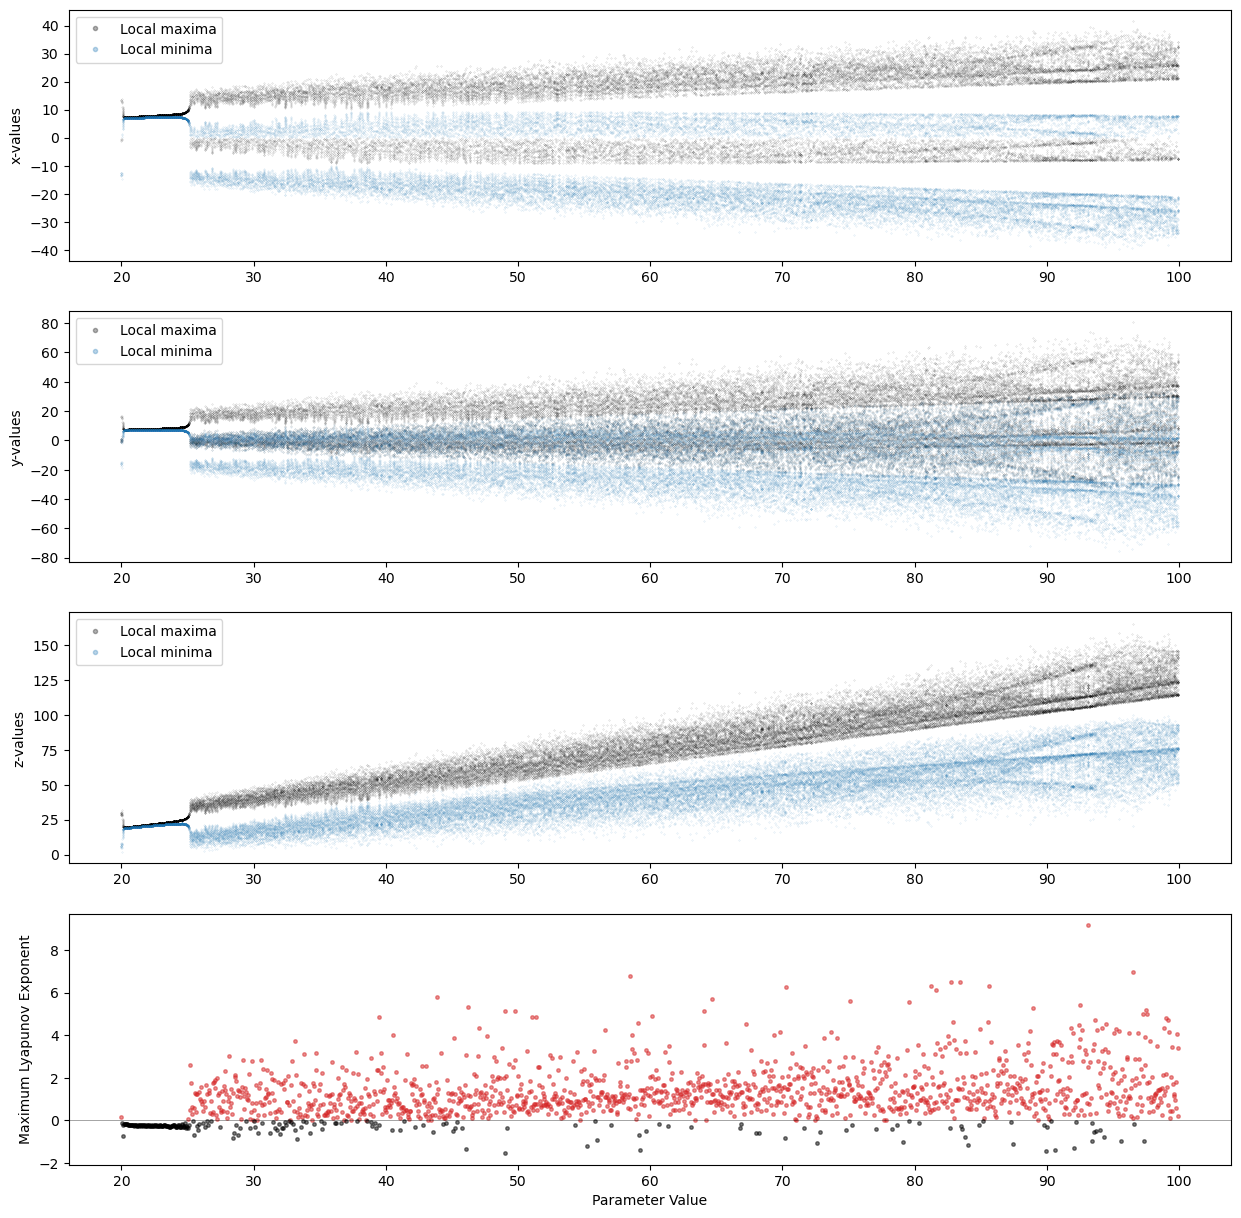

In [45]:
plot_bifurcation_diagram(func=lorenz, func_jac=lorenz_jac, 
                         x0=x0, time_vector=t, 
                         parameters=params, p_idx=1, max_time=500)

- The function generated 4 plots.
- The first 3 are bifurcation diagrams for the system's variables $x$, $y$, and $z$.
- The last plot shows the largest value among the 3 Lyapunov exponents.
- We see a relationship between the Lyapunov exponents and the onset of chaos in the system.
- When the largest Lyapunov exponent is positive, the system shows a chaotic behavior along at least one direction.

```{hint}
- If running `plot_bifurcation_diagram` takes too long, try reducing the number of configuration explored.
- For example, try `rho_values = np.arange(20, 100, 0.5)`.
```

## Phase space

- The current state of a system is treated as a point in the *phase space* or *state space*.
- The phase space represents all the possible states of a system.
- It describes how system variables $x, y, z, \dots$ interact and evolve.

<img src="media/phase_space.png" style="width: 100%; display: block; margin: auto;">

- The phase space gives us complete knowledge about the current state of system.
- We are particularly interested its *trajectory* (or orbit) over time.
- Knowing it, allows us to make predictions about future states of the system.
- Clearly, this is of key importance in time series forecasting.

<img src="media/predict.png" style="width: 40%; display: block; margin: auto;">

- To identify the trajectory of the system in the phase space, we have to identify properties of its attractor.
- One of these, is its *dimensionality*.
- To determine the dimensionality of an attractor, especially strange attractors of chaotics systems, we have to revise our concept of dimensionality.

---

## Fractal dimensions

- We commonly understand dimensions from a geometric perspective: length, width, depth.
- Common geometrical objects such as a line, a square, or a cube require an increasing number of dimensions to contain them.

- The concept of dimensions is also tied to common measures on these objects such as their perimeter, area, and volume, which require an increasing number of dimensions to express them.

<img src="media/dimensions.png" style="width: 50%; display: block; margin: auto;">

- In this perspective, dimensions are integers and the idea of a fractional dimension, e.g., $d=1.26$, makes little sense.

- Let's now take a different approach.
- Let's think at dimensions as *how much they scale up* some quantity.
- For example, let's double the edge of a square.
- The perimeter will grow by a factor of 2, while the area by a factor of 4. 
- If we double the edge of a cube its volume gets 8 times bigger.

- Similarly, we can divide an edge into $r$ pieces and counting how many parts we obtain.
- Let $r$ be the *scaling factor* and $N$ the number of pieces we obtain.
- For the line is straightforward:

<img src="media/line.png" style="width: 40%; display: block; margin: auto;">


| $r$ | $N$ |
|:-----:|:-----:|
| 1 | 1 |
| 2 | 2 |
| 4 | 4 |

- We can derive the following rule: $N=r^D$ with $D=1$.

- Let's move to the square and repeat the same computations.

<img src="media/square.png" style="width: 40%; display: block; margin: auto;">

| $r$ | $N$ |
|:-----:|:-----:|
| 1 | 1 |
| 2 | 4 |
| 4 | 16 |

- The same rule as before applies, $N=r^D$, but now $D=2$.

- Finally, for the cube we have:

<img src="media/cube.png" style="width: 40%; display: block; margin: auto;">

| $r$ | $N$ |
|:-----:|:-----:|
| 1 | 1 |
| 2 | 8 |
| 4 | 64 |

- The number of pieces is still $N=r^D$ when $D=3$.
- So far, the value of $D$ aligns with how we are used to perceive the dimensionality of these objects.

- Next, we move to a *fractal* object, called Koch curve (or Koch snowflake).
- We try to approximate the length of the curve with segments of decreasing length.
- Let's start with a segment of length $r=1$.

<img src="media/koch1.png" style="width: 55%; display: block; margin: auto;">

- If we split the segment in $r=3$, we can fit $N=4$ pieces.

<img src="media/koch2.png" style="width: 55%; display: block; margin: auto;">

- If we split it in $r=9$, we can fit $N=16$ pieces, and so on.

<img src="media/koch3.png" style="width: 55%; display: block; margin: auto;">

- The relationship that we defined before, $N=r^D$, is the key to find the dimensionality of this fractal object.
- In particular, we have 

$$4 = 3^D \rightarrow \log(4) = \log(3)\cdot D \rightarrow = D = \frac{\log(4)}{\log(3)} \approx 1.26 $$

- Intuitively, think that we need more "dimensionality" to contain this object than what we need to contain a line, but less than what we need to contain an area.

- Another example is the Sierpinski triangle.

<img src="media/triangle.png" style="width: 70%; display: block; margin: auto;">

- Following the same procedure, we have that $D = \frac{\log(3)}{\log(2)} \approx  1.58$.
- Clearly, we need more "dimensionality" to contain this object than the Koch curve, but, due to all the "holes", still less than an area.

### Chaos and Fractals

- There is a deep and ubiquitous connection between chaos and fractals.
- For example, some bifurcation diagrams are self-similar.

- If we zoom-in on the value $r \approx 3.83$ of the bifurcation diagram of the Logistic map, the situation nearby looks like a shrunk and slightly distorted version of the whole diagram. 
- The same is true for all other non-chaotic points. 

<img src="media/logistic-zoom.gif" style="width: 60%; display: block; margin: auto;">

<div style="text-align: center; font-size: 15px;">Image: <a href="https://github.com/jonnyhyman/Chaos">jonnyhyman</a></div>

- Another beautiful relationship is the one between the Mandelbrot Set and the bifurcation map of the Logistic map.


<img src="media/Logistic_Map_Bifurcations_Underneath_Mandelbrot_Set.gif" style="width: 55%; display: block; margin: auto;">

<div style="text-align: center; font-size: 15px;">Image: <a href="https://github.com/jonnyhyman/Chaos">jonnyhyman</a></div>

- The trajectory of a strange attractor does not fill the phase space, but only a fraction of it.
- In other words, the dimensionality of the attractor of a chaotic system is fractal.
- Determining such dimensionality is key to *reconstruct* the phase space.

---

## Phase space reconstruction

- As for the previous examples, dynamical systems are often governed by the evolution of several interacting variables $x_1, x_2, \dots, x_D$.
- In most realistic scenarios, however, we cannot directly observe all system's variables.
- We can only measure *partial observations*, i.e., a subset of the system's variables or a function of them $y = f(x_1, x_2, \dots, x_D)$.

<img src="media/partial.png" style="width: 40%; display: block; margin: auto;">

**Examples**
- In the Lorenz system, we might observe only the variable $y(t)$.
- In weather forecasting, meteorologists often have access only to partial observations of a subset of variables such as temperature, pressure, humidity, wind patterns, and geographic features. However, there are many other variables that are inaccessible such as detailed atmospheric conditions, microclimates, oceans' temperatures, currents, the presence of pollutants, variations in solar radiation, etc..

- Can we reconstruct the trajectory of the system in the state space from partial observations?
- If we are able to do so, we can predict the future states of the systems, including the observed time series.

<img src="media/reconstruct.png" style="width: 60%; display: block; margin: auto;">

### Takens' Embedding Theorem

- Assume a dynamical system with an unknown or partially known state space.
- Takens' Embedding Theorem says that it is possible to reconstruct the dynamics of the whole system using a series of observations from a *single* variable.
- This means that even if we cannot observe the entire state of a system directly, we can still understand its dynamics through proper analysis of a single observable variable.

**Time-delay embedding vector**
- Let $x(t)$ be the observed time series.
- The embedding vector $\mathbf{e}(t) = [e_1, e_2, \dots, e_m]$ is defined as:

$$\begin{align} e_1(t) &= x(t) \\ e_2(t) &= x(t + \tau) \\ e_3(t) &= x(t + 2\tau) \\ \dots \\ e_m(t) &= x(t + (m-1)\tau) \end{align}$$

- Here, $\tau$ is a chosen *time delay* and $m$ is the *embedding dimension*.

In [46]:
def takens_embedding(data, delay, dimension):
    embedding = np.array([data[0:len(data)-delay*dimension]])
    for i in range(1, dimension):
        embedding = np.append(embedding, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)
    return embedding.transpose()

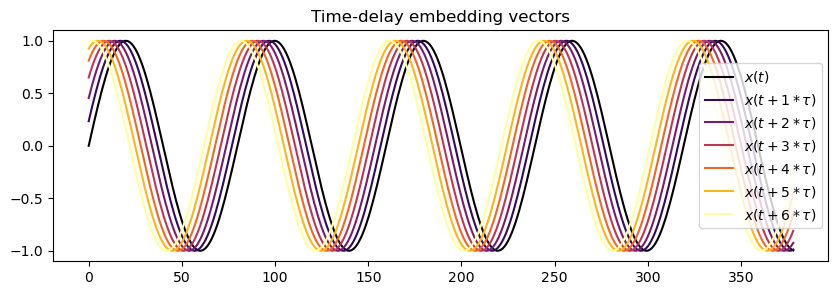

In [47]:
t = np.linspace(0, 10*np.pi, 400)
x = np.sin(t)                      # time series
tau = 3                            # time delay
N = 7                              # embedding dimension
emb = takens_embedding(x, tau, N)  # compute embeddings

cmap = plt.get_cmap('inferno')
fig, ax = plt.subplots(1,1, figsize=(10,3))
for i in range(N):
    _label = f"$x(t + {i}*\\tau )$" if i > 0 else f'$x(t)$'
    ax.plot(emb[:,i], label=_label, color=cmap(i / (N - 1)))
plt.legend()
plt.title('Time-delay embedding vectors');

**Theorem formulation**

<img src="media/takens.png" style="width: 60%; display: block; margin: auto;">

- Takens' theorem does not specify how to choose $m$ and $\tau$.
- It only asserts that for a system with an attractor of (fractional) dimension $D$, an embedding dimension $m > 2D$ is sufficient to ensure a *diffeomorphic* (i.e., topologically equivalent) embedding under generic conditions.
- Intuitively, the embedding dimension must be large enough to unfold the attractor fully in the reconstructed phase space, capturing its dynamics without self-intersections. 
- How do we estimate $m$ and $\tau$ from a single time series?

#### Estimating time delay $\tau$

- We can rely on *mutual information* (MI) to compute $\tau$.
- MI quantifies the amount of information between two random variables.
- We want to compute the MI w.r.t. the time series and its lagged version. 
- Think of MI as a more powerful autocorrelation that captures also non-linear relationships.
- When MI reaches its minumum for a certain lag $\tau$, it means that the the observations become sufficiently independent while still retaining meaningful information about the dynamics of the system.

1. Compute the minimum $x_\text{min}$ and maximum $x_\text{max}$ of the time series.
2. Split the interval $[x_\text{min}, x_\text{max}]$ into $n_\text{bins}$ bins.
3. Denote $p_t(h)$ the probability that an element of $x(t)$ is in the $h$-th bin.
4. Denote $p_{t+\tau}(k)$ the probability that an element of $x(t+\tau)$ is in the $k$-th bin.
5. Denote $p_{t, t+\tau}(h, k)$ the probability that $x(t)$ is in the $h$-th bin, while $x(t+\tau)$ is in the $k$-th bin.

6. Define the MI as 

$$I(\tau) = - \sum \limits_{h=1}^{n_\text{bins}} \sum \limits_{k=1}^{n_\text{bins}} p_{t, t+\tau}(h, k) \log \frac{p_{t, t+\tau}(h, k)}{p_t(h) \cdot p_{t+\tau}(k)}$$

7. Compute $\tau^* = \text{argmin}_\tau I(\tau)$. 

- Let's write a Python code to compute the MI for a time series and lagged versions of itself.
- As an example, we consider the time series $x(t)$ from the Rössler system.

In [48]:
# Parameters
a, b, c = 0.2, 0.2, 5.7
y0 = [0.0, 2.0, 0.0]  # Initial conditions
T = 1500 # Final time
t_span = [0, T]  # Time span for the integration

# Solve the differential equations
solution = solve_ivp(rossler_system, t_span, y0, args=(a, b, c), dense_output=True)
t = np.linspace(0, T, int(5e3))
ross_sol = solution.sol(t)

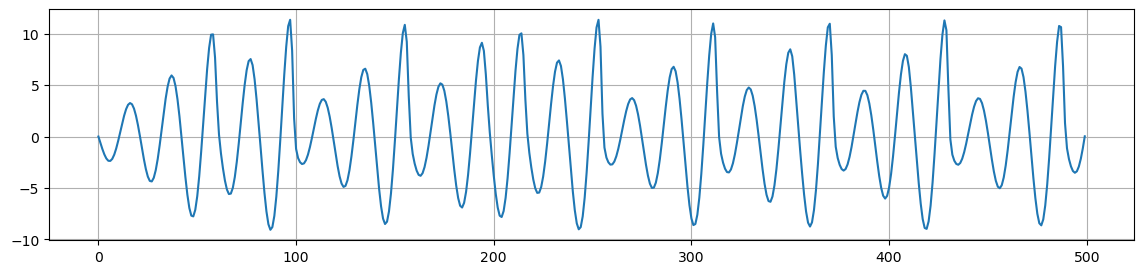

In [49]:
ross_ts = ross_sol[0]
plt.figure(figsize=(14,3))
plt.plot(ross_ts[:500])
plt.grid()
plt.show()

In [50]:
def mutual_information(data, delay, n_bins):
    """
    Calculate the mutual information for a given delay using histograms.
    """
    # Prepare delayed data
    delayed_data = data[delay:]
    original_data = data[:-delay]
    
    # Compute histograms
    p_x, bin_edges = np.histogram(original_data, bins=n_bins, density=True)
    p_y, _ = np.histogram(delayed_data, bins=bin_edges, density=True)
    p_xy, _, _ = np.histogram2d(original_data, delayed_data, bins=bin_edges, density=True)
    
    # Calculate mutual information
    mutual_info = 0
    for i in range(n_bins):
        for j in range(n_bins):
            if p_xy[i, j] > 0 and p_x[i] > 0 and p_y[j] > 0:
                mutual_info += p_xy[i, j] * np.log(p_xy[i, j] / (p_x[i] * p_y[j]))
    
    return mutual_info

- Now we calculate the MI for different values of $\tau$, display it, and find its first minimum. 
- This gives us the optimal embedding delay. 
- We use 50 bins and, since we have 5000 data points, we will have 100 points in each bin.

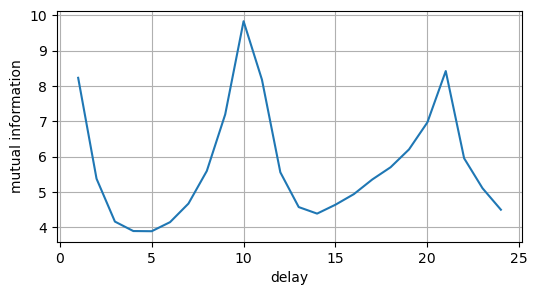

In [51]:
MI = []
for i in range(1,25):
    MI = np.append(MI,[mutual_information(ross_ts,i,50)])
plt.figure(figsize=(6,3))
plt.plot(range(1,25), MI)
plt.xlabel('delay')
plt.ylabel('mutual information')
plt.grid()
plt.show()

- We see that the optimal value of $\tau$ is $4$ or $5$.

```{note}
- Things change quite a lot if data are sampled with different frequencies.
- In this example we used `t = np.linspace(0, 1500, int(5e3))`.
- Try to see how things change for `t = np.linspace(0, 500, int(5e4))` the time vector we used before to draw the attractor in the [Rössler system](#rossler-system).
- The result is also influenced by the value of `n_bins`.
    - Choosing these kind of hyperparameters is often a sensitive choice in estimators for information theoretical quantities such as the MI.
```

#### Estimating the embedding dimension $m$

- We can estimate $m$ by using a measure called *false nearest neighbours* (FNN). 
- The *false neighbors* are points that appear close in lower dimensions due to projection, but are not actually close in the higher-dimensional space.
- The main idea behind FNN is to increase the embedding dimension until the fraction of false neighbors falls below a certain threshold. 

1. Start with a low embedding dimension $m=1$ and compute the time-delayed reconstructions of the phase space.

2. For each point in the reconstructed phase space, identify its nearest neighbor.

3. Calculate the distance between each point and its nearest neighbor in the current embedding dimension $m$ and then in the next higher dimension $m+1$.

4. Determine if the neighbor is 'false' by checking if the distance between the point and its nearest neighbor increases significantly when moving from dimension $m$ to $m+1$. A neighbor is considered false if:

$$\frac{|R_{m+1} - R_m|}{R_m} > R_{tol}$$ 

- where 
    - $R_m$ is the distance between the point and its nearest neighbor in dimension $m$, 
    - $R_{m+1}$ is the distance in dimension $m+1$, 
    - $R_{tol}$ is a threshold for deciding if the increase in distance is significant.

5. Compute the fraction of false nearest neighbors for the current dimension.

6. Repeat the process by increasing $m$ until the fraction of false nearest neighbors a sufficiently low value indicating that the attractor is completely unfolded.

In [53]:
def calculate_fnn(data, delay, max_emb_dim, R_tol=10):
    fnn_proportions = []
    for m in range(1, max_emb_dim + 1):
        
        # Compute embeddings in m and m+1
        emb_m = takens_embedding(data, delay, m)
        emb_m_plus_one = takens_embedding(data, delay, m + 1)
        
        # Compute the nearest neighbors in m
        nbrs = NearestNeighbors(n_neighbors=2).fit(emb_m[:-delay])
        distances, indices = nbrs.kneighbors(emb_m[:-delay])

        n_false_nn = 0
        for i in range(0, len(distances)): 
            
            # Nearest neighbor of i in m and distance from it
            neighbor_index, R_m = indices[i, 1], distances[i, 1]
            
            # Dinstance in m+1 from the nearest neighbor in m
            R_m_plus_one = np.linalg.norm(emb_m_plus_one[i] - emb_m_plus_one[neighbor_index]) 

            # fNN formula
            if abs(R_m_plus_one - R_m) / R_m > R_tol:
                n_false_nn += 1
        
        fnn_proportion = n_false_nn / len(indices)
        fnn_proportions.append(fnn_proportion)
        
    return fnn_proportions

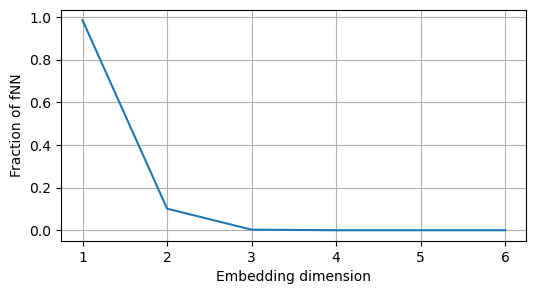

In [54]:
nFNN = calculate_fnn(ross_ts, delay=5, max_emb_dim=6)

plt.figure(figsize=(6,3))
plt.plot(range(1,len(nFNN)+1),nFNN);
plt.xlabel('Embedding dimension')
plt.ylabel('Fraction of fNN')
plt.grid()
plt.show()

- As we can see, the fraction of fNN drops to zero for $m=3$.
- This makes sense, since we we know that the Rössler system has 3 state variables and its attractor is contained in more than 2 dimensions.
- We are finally ready to reconstruct the attractor.

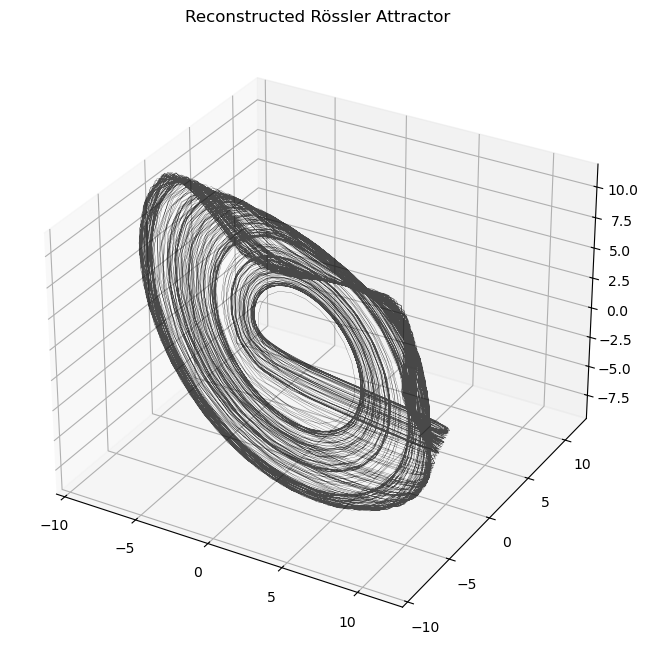

In [55]:
emb = takens_embedding(ross_ts, delay=5, dimension=3)
plot_attractor(emb.T, title="Reconstructed Rössler Attractor", interactive=False)

- The reconstruction closely resemble the original attractor.
- Remember that the reconstructed attractor needs not to be equal to the actual attractor but only diffeomorphic (topologically equivalent) to it.

---

## Forecasting nonlinear time series

### Regression on the Taken's embeddings

- Taken's embeddings are related to the windowed approach for forecasting that we saw in the previous lecture.
- In the following, we show the relationship through a practical forecasting example.

- Given a time series $\{x(t)\}_{t = 1, 2, \dots, T}$, a time delay $\tau$, and an embedding dimension $m$, the matrix $\mathbf{E}$ of Takens' embeddings can be represented as:

$$
\mathbf{E} = \begin{pmatrix}
x(t)           & x(t+\tau)      & x(t+2\tau)     & \dots  & x(t+(m-1)\tau) \\
x(t+1)         & x(t+\tau+1)    & x(t+2\tau+1)   & \dots  & x(t+(m-1)\tau+1) \\
x(t+2)         & x(t+\tau+2)    & x(t+2\tau+2)   & \dots  & x(t+(m-1)\tau+2) \\
\vdots         & \vdots         & \vdots         & \ddots & \vdots \\
x(T-(m-1)\tau) & x(T-(m-2)\tau) & x(T-(m-3)\tau) & \dots  & x(T) \\
\end{pmatrix}
$$

- Each row should contain enough information to describe the dynamics of the system at a certain time step.
- We can use this information to make future predictions.
- For example, we can use the first row $[x(t), x(t+\tau),  x(t+2\tau) \dots  x(t+(m-1)\tau)]$ to predict the next value $x(t+m\tau)$.

- First, we compute the embeddings using as dimension $m+1$.
- Then, we will use as input all the columns of $\mathbf{E}$ except the last one, `emb[:,:-1]`, which will be the target.
- This corresponds to taking a window of size $m$ of samples taken every $\tau$ time steps and making a prediction $\tau$ steps ahead.
- In the example below we will use the `RandomForestRegressor` as the regression model.

In [56]:
def forecast_on_phase_space(y, delay, dimension, test_prop):
    # Compute embeddings
    emb = takens_embedding(y, delay=delay, dimension=dimension)
    
    # Create input and target
    X = emb[:, :-1]
    y = emb[:, -1]
    
    # Divide into train and test
    test_size = int(len(y)*test_prop)
    X_train = X[:-test_size, :]
    y_train = y[:-test_size]
    X_test = X[-test_size:, :]
    y_test = y[-test_size:]
    
    # Fit the regressor on the training data
    rf = RandomForestRegressor().fit(X_train, y_train)
    
    # Predict the test data
    preds = rf.predict(X_test)

    print(f'MSE: {mean_squared_error(y_test, preds):.3f}')
    plt.figure(figsize=(14,3))
    plt.plot(y_test, label='True')
    plt.plot(preds, label='Prediction')
    plt.grid()
    plt.legend();

MSE: 0.080


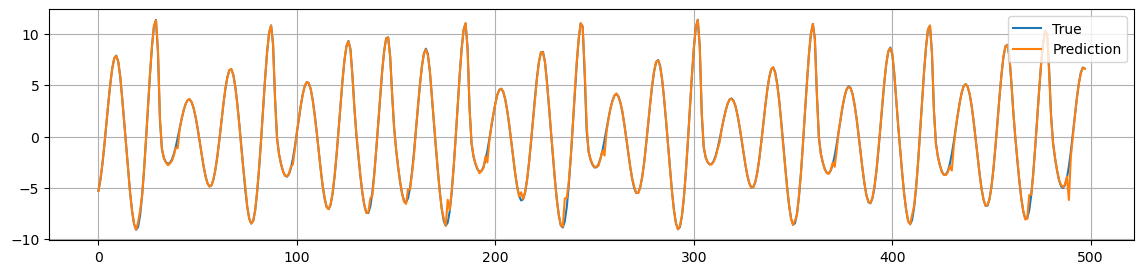

In [57]:
forecast_on_phase_space(ross_ts, delay=5, dimension=3+1, test_prop=0.1)

- As we can see, we obtain a pretty good prediction.
- This means that the window $[x(t), x(t+\tau),  x(t+2\tau) \dots  x(t+(m-1)\tau)]$ contains enough information to predict the next value $x(t+m\tau)$.

### Echo State Network

- Rather than using the time embeddings, we can use the states of the Reservoir of an Echo State Network as input for our regression model.
- We will perform the same prediction $\tau$-steps ahead.

In [58]:
Xtr, Ytr, Xte, Yte, scaler = make_forecasting_dataset(ross_ts[:,None], 
                                                  horizon=5,
                                                  test_percent = 0.1)
print(f"Xtr shape: {Xtr.shape}\nYtr shape: {Ytr.shape}\nXte shape: {Xte.shape}\nYte shape: {Yte.shape}")

Xtr shape: (4495, 2)
Ytr shape: (4495, 1)
Xte shape: (495, 2)
Yte shape: (495, 1)


- Next, we initialize the Reservoir and compute the states.

In [59]:
res= Reservoir(n_internal_units=900,
               spectral_radius=0.99,
               input_scaling=0.1,
               connectivity=0.25)

n_drop=10
states_tr = res.get_states(Xtr[None,:,:], n_drop=n_drop, bidir=False)
states_te = res.get_states(Xte[None,:,:], n_drop=n_drop, bidir=False)
print(f"states_tr shape: {states_tr.shape}\nstates_te shape: {states_te.shape}")

states_tr shape: (1, 4485, 900)
states_te shape: (1, 485, 900)


- Next, we will reduce the dimensionality of the Reservoir states with PCA.
- This will make fitting the regression model faster.
- Usually, we would choose a reasonably large number, e.g., $50$.
- However, here we will reduce the number of dimension to $m=3$.
- This will allow us to produce an interesting visualization later.

In [60]:
pca = PCA(n_components=3)
states_tr_pca = pca.fit_transform(states_tr[0])
states_te_pca = pca.transform(states_te[0])
print(f"states_tr shape: {states_tr_pca.shape}\nstates_te shape: {states_te_pca.shape}")

states_tr shape: (4485, 3)
states_te shape: (485, 3)


- Next, we fit the regression model to the Reservoir states and compute the predictions.
- Note how good the predictions are even if we use such small states.

In [61]:
# Fit the regression model
rf = RandomForestRegressor().fit(states_tr_pca, Ytr[n_drop:,:].ravel())

# Compute the predictions
Yhat_pca = rf.predict(states_te_pca)[...,None]

# Compute the mean squared error
mse = mean_squared_error(scaler.inverse_transform(Yhat_pca), Yte[n_drop:,:])
print(f"MSE: {mse:.2f}")

MSE: 0.25


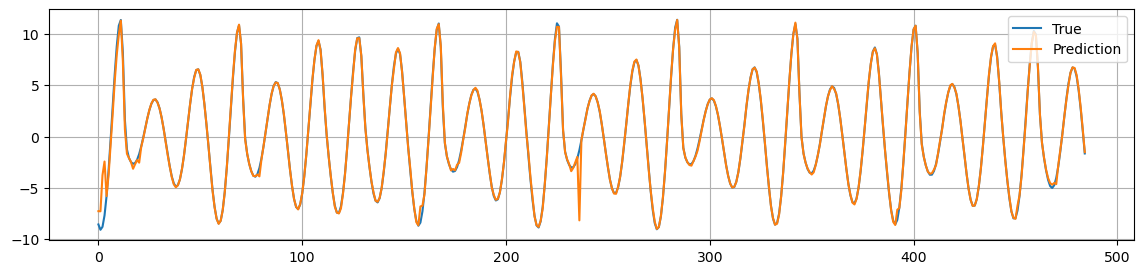

In [62]:
plt.figure(figsize=(14,3))
plt.plot(Yte[n_drop:,:], label='True')
plt.plot(scaler.inverse_transform(Yhat_pca), label='Prediction')
plt.legend()
plt.grid()
plt.show()

- The ESN is particular good in predicting non-linear time series and chaotic systems in general.
- The reason is that the Reservoir manages very well to reproduce the dynamics in the underlying system.
- To convince ourselves, we can can plot the dynamics of the Reservoir states and observe how closely follows the trajectory of the actual phase space.

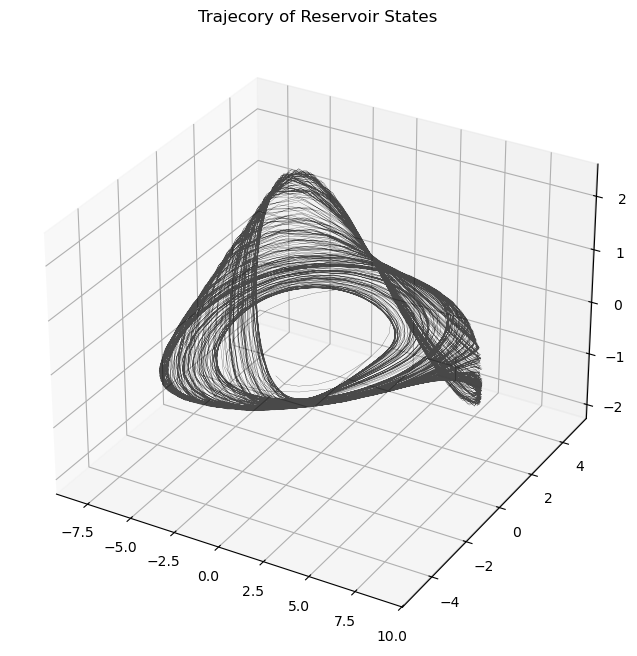

In [63]:
plot_attractor(states_tr_pca.T, title="Trajecory of Reservoir States", interactive=False)

---
## Exercises 

### Excercise 1

- Compute the bifurcation map of the Rössler system.
- Keep fixed the parameters $a = b = 0.2$
- Vary the parameter $c$ as shown below.
- For each value of $c$, compute and plot the local maxima of the time series $z(t)$ using the function `scipy.signal.find_peaks`. You should obtain a plot that resembles the figure below.
- Identify the first bifurcation point before the system becomes chaotic.
- Explain why computing the local maxima (peaks) was not necessary for the logistic map.

<img src="media/rossler_attractor.png" style="width: 100%; display: block; margin: auto;">

In [63]:
c_values = np.linspace(2, 15, 300) # value of c to explore

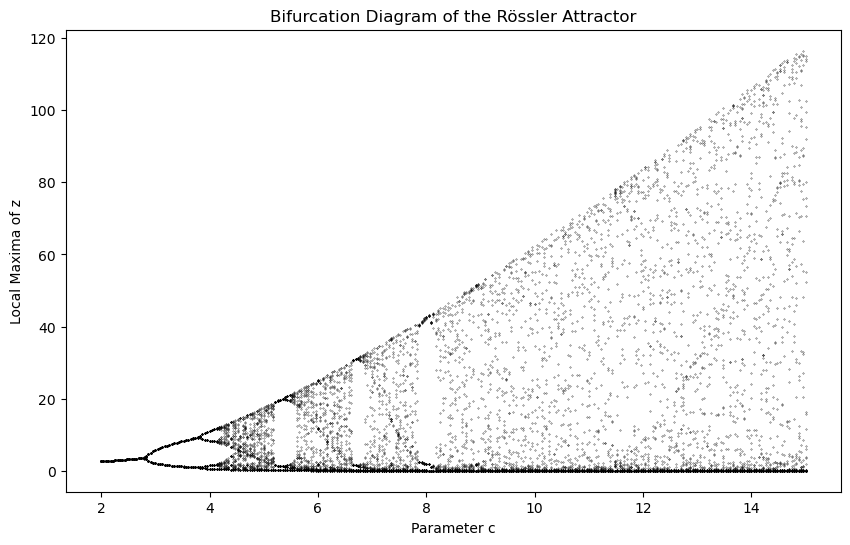

In [ ]:
from scipy.signal import find_peaks  # Added as needed for peak detection

# Define the Rossler system
def rossler(t, state, a, b, c):
    x, y, z = state
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

# Fixed parameters
a = 0.2
b = 0.2

# Values of c to explore
c_values = np.linspace(2, 15, 300)

# Time vector for integration
t_max = 500
t_eval = np.linspace(0, t_max, 10000)

# Initial condition
initial_state = [1.0, 1.0, 1.0]

# Prepare lists to collect results
c_list = []
z_maxima_list = []

# Loop over c values
for c in c_values:
    sol = solve_ivp(rossler, [0, t_max], initial_state, args=(a, b, c), t_eval=t_eval, rtol=1e-8, atol=1e-10)
    z = sol.y[2]

    # Remove transient part
    transient_cutoff = int(0.5 * len(z))
    z_ss = z[transient_cutoff:]

    # Find local maxima
    peaks, _ = find_peaks(z_ss)
    z_maxima = z_ss[peaks]

    # Store results
    c_list.extend([c] * len(z_maxima))
    z_maxima_list.extend(z_maxima)

# Plot bifurcation diagram
plt.figure(figsize=(10, 6))
plt.plot(c_list, z_maxima_list, 'k.', markersize=0.5)
plt.title("Bifurcation Diagram of the Rössler Attractor")
plt.xlabel("Parameter c")
plt.ylabel("Local Maxima of z")
plt.show()

# About 10 minutes to run.

In [ ]:
# The bifurcation point is approximately around: c ≈ 4.2 to 4.4

# In the logistic map, the system is already sampled at each iteration; the state space is discrete. 
# Therefore, all dynamic information is directly available from successive values 𝑥_𝑛, 
# making local maxima extraction unnecessary.

### Exercise 2

- Compute the (fractal) dimension of the object in the figure below.

<img src="media/menger-sr.jpeg" style="width: 40%; display: block; margin: auto;">

In [ ]:
# Compute fractal dimension of Menger sponge

# Number of self-similar pieces
N = 20

# Scaling factor
S = 3

# Fractal dimension formula
D = np.log(N) / np.log(S)

print(f"Fractal dimension of the Menger sponge: {D:.5f}")

Fractal dimension of the Menger sponge: 2.72683


### Exercise 3

- Plot the Lorenz attractor for $\sigma = 10$, $\rho = 28$, and $\beta = \frac{8}{3}$.

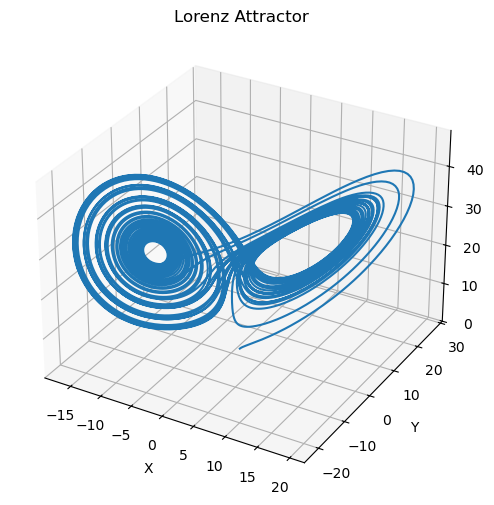

In [66]:
# Lorenz attractor

# Parameters
sigma = 10
rho = 28
beta = 8 / 3

# Lorenz system definition
def lorenz(t, state):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Initial condition
initial_state = [1.0, 1.0, 1.0]

# Time span
t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solve ODE
sol = solve_ivp(lorenz, t_span, initial_state, t_eval=t_eval)

# Plotting
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])
ax.set_title("Lorenz Attractor")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


### Exercise 4

- Use the Taken's embedding to reconstruct the Lorenz attractor from the time series of its first state variable $x(t)$.
- Compute the optimal time delay $\tau$ and the optimal embedding dimension $m$ using the Mutual Information and the false Nearest-Neighbors algorithms.

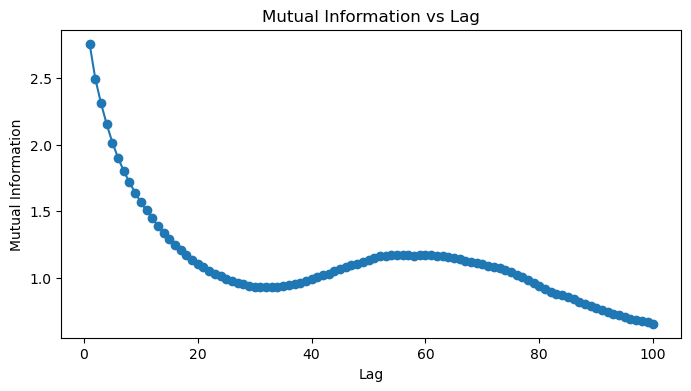

Optimal time delay (tau): 31


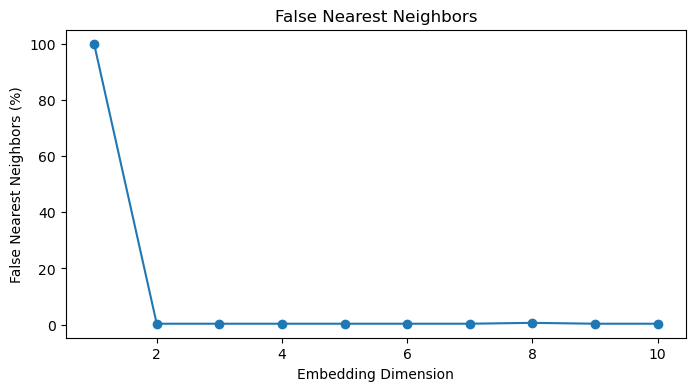

Optimal embedding dimension (m): 2


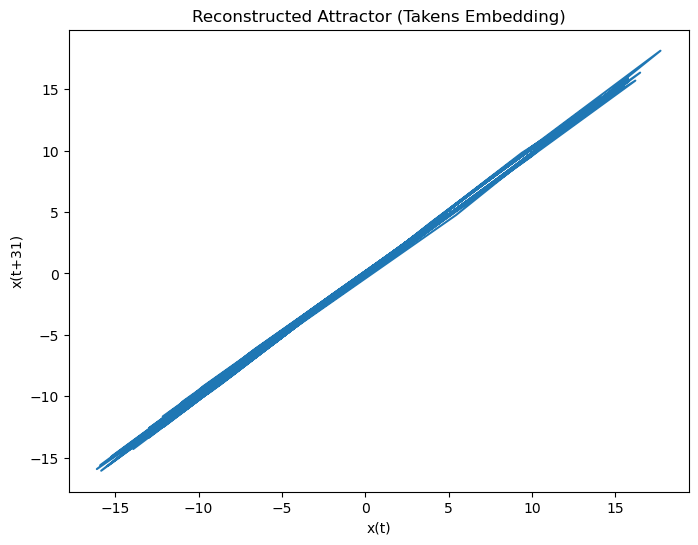

In [69]:
# Extract x(t) from previous Lorenz solution
x_t = sol.y[0]

# --- 1. Compute optimal time delay tau using mutual information ---

from sklearn.metrics import mutual_info_score

def compute_mutual_information(x, max_lag, bins=32):
    mi = []
    for lag in range(1, max_lag+1):
        mi.append(mutual_info_score(
            np.digitize(x[:-lag], bins=np.histogram_bin_edges(x, bins=bins)),
            np.digitize(x[lag:], bins=np.histogram_bin_edges(x, bins=bins))
        ))
    return np.array(mi)

max_lag = 100
mi = compute_mutual_information(x_t, max_lag)

plt.figure(figsize=(8,4))
plt.plot(range(1, max_lag+1), mi, marker='o')
plt.xlabel("Lag")
plt.ylabel("Mutual Information")
plt.title("Mutual Information vs Lag")
plt.show()

from scipy.signal import argrelextrema

minima = argrelextrema(mi, np.less)[0]
tau_opt = minima[0]+1 if len(minima)>0 else 10

print(f"Optimal time delay (tau): {tau_opt}")

# --- 2. Compute optimal embedding dimension m using False Nearest Neighbors ---

from scipy.spatial import cKDTree

def embed_ts(ts, m, tau):
    N = len(ts) - (m-1)*tau
    return np.array([ts[i : i + N*tau : tau] for i in range(m)]).T

def false_nearest_neighbors(ts, tau, max_dim, R_thresh=10.0, A_thresh=2.0):
    N = len(ts) - max_dim*tau
    fnn_percent = []
    
    for m in range(1, max_dim+1):
        Y_m = embed_ts(ts, m, tau)
        tree = cKDTree(Y_m)
        dist, ind = tree.query(Y_m, k=2)
        nearest = ind[:,1]
        
        if m == 1:
            fnn_percent.append(100.0)
            continue
        
        Y_m1 = embed_ts(ts, m+1, tau)
        dist_m = np.linalg.norm(Y_m1 - Y_m1[nearest], axis=1)
        R = dist[:,1]
        F1 = (dist_m - R) / R
        F2 = np.abs(Y_m1[:,-1] - Y_m1[nearest,-1])
        
        fnn = np.sum((F1 > R_thresh) | (F2 > A_thresh)) / len(R)
        fnn_percent.append(fnn*100)
    
    return fnn_percent

max_dim = 10
fnn_percent = false_nearest_neighbors(x_t, tau_opt, max_dim)

plt.figure(figsize=(8,4))
plt.plot(range(1, max_dim+1), fnn_percent, marker='o')
plt.xlabel("Embedding Dimension")
plt.ylabel("False Nearest Neighbors (%)")
plt.title("False Nearest Neighbors")
plt.show()

# Select embedding dimension where FNN ~ 0
m_opt = next((i+1 for i, v in enumerate(fnn_percent) if v < 1.0), 3)

print(f"Optimal embedding dimension (m): {m_opt}")

# --- 3. Reconstruct attractor with Takens embedding ---

embedded = embed_ts(x_t, m_opt, tau_opt)

fig = plt.figure(figsize=(8,6))

if m_opt >= 3:
    ax = fig.add_subplot(projection='3d')
    ax.plot(embedded[:,0], embedded[:,1], embedded[:,2])
    ax.set_title("Reconstructed Attractor (Takens Embedding)")
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t+{tau_opt})")
    ax.set_zlabel(f"x(t+{2*tau_opt})")
else:
    plt.plot(embedded[:,0], embedded[:,1])
    plt.title("Reconstructed Attractor (Takens Embedding)")
    plt.xlabel("x(t)")
    plt.ylabel(f"x(t+{tau_opt})")

plt.show()


### Exercise 5

- Compute the predictions of the state variable $x(t)$ of the Lorenz system using the Taken's delay embeddings and a regression algorithm of your choice (Ridge Regression, Random Forest, etc...).

Test MSE: 36.09552


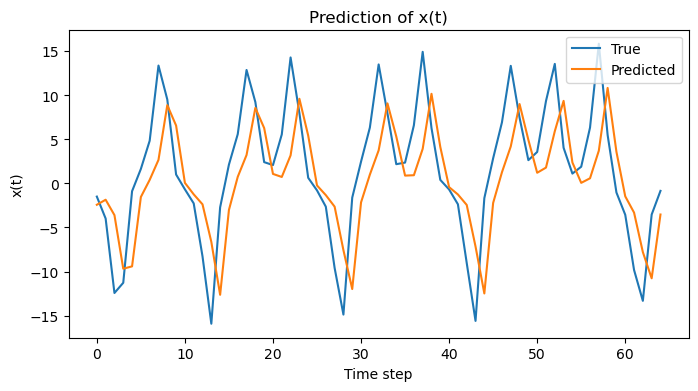

In [70]:
# --- 1. Prepare data for supervised learning ---

# Input: first m-1 dimensions
X = embedded[:-1, :-1]

# Target: last dimension shifted by one
y = embedded[1:, -1]

# Train-test split (e.g. 80% train, 20% test)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- 2. Fit Ridge Regression ---

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.5f}")

# --- 3. Plot actual vs predicted ---

plt.figure(figsize=(8,4))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("Prediction of x(t)")
plt.xlabel("Time step")
plt.ylabel("x(t)")
plt.show()


### Exercise 6

- Compute the predictions of the state variable $x(t)$ of the Lorenz system with an ESN using a forecast horizon of your choice.
- Make a 3D plot of the Reservoir states reduced to 3 dimensions with PCA and compare it to the actual Lorenz attractor.

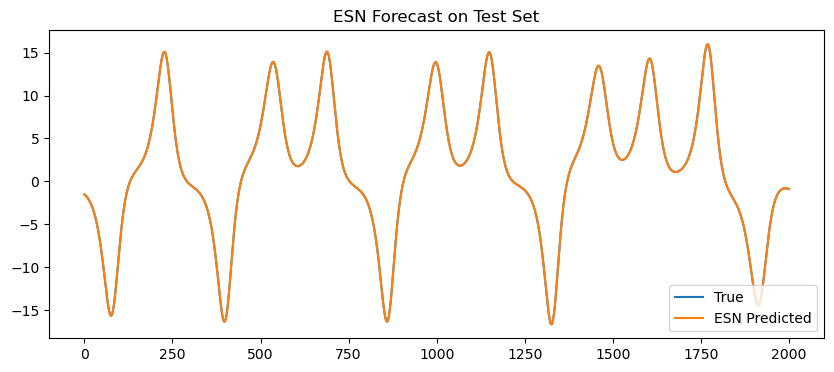

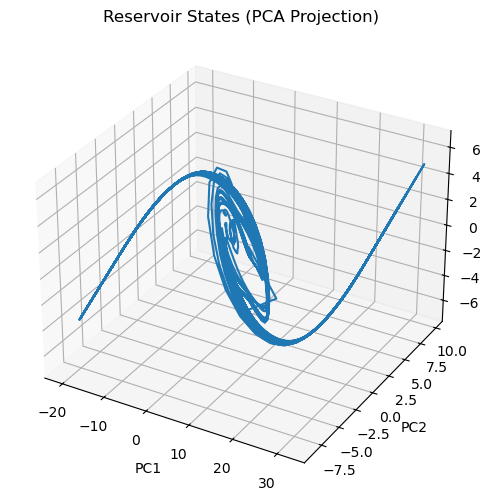

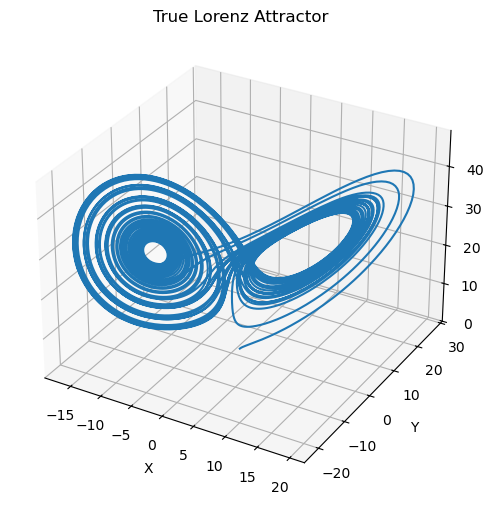

In [71]:
# ------------- ESN Implementation -------------

class ESN:
    def __init__(self, n_inputs, n_reservoir, spectral_radius=0.95, sparsity=0.1, noise=0.001, random_state=None):
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.noise = noise
        self.random_state = np.random.RandomState(random_state)
        
        # Input weights
        self.Win = (self.random_state.rand(self.n_reservoir, self.n_inputs) - 0.5) * 2
        
        # Reservoir weights
        W = self.random_state.rand(self.n_reservoir, self.n_reservoir) - 0.5
        W[self.random_state.rand(*W.shape) > self.sparsity] = 0
        # Normalize to set spectral radius
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W * (self.spectral_radius / radius)
    
    def fit(self, inputs, outputs, washout=100, ridge_param=1e-6):
        states = self.get_states(inputs)
        self.Wout = np.linalg.solve(
            states[washout:].T @ states[washout:] + ridge_param * np.eye(states.shape[1]),
            states[washout:].T @ outputs[washout:]
        )
    
    def get_states(self, inputs):
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for t in range(1, inputs.shape[0]):
            states[t] = np.tanh(
                self.Win @ inputs[t] + self.W @ states[t-1] + self.noise * (self.random_state.rand(self.n_reservoir) - 0.5)
            )
        extended_states = np.hstack([states, inputs])
        return extended_states
    
    def predict(self, inputs):
        states = self.get_states(inputs)
        return states @ self.Wout

# ------------- Prepare data -------------

# We'll forecast x(t) directly
x_t = sol.y[0]
x_t = x_t.reshape(-1, 1)  # shape (n_samples, n_features)

# Train/test split
train_len = 8000
test_len = len(x_t) - train_len

x_train, x_test = x_t[:train_len], x_t[train_len:]

# ------------- Train ESN -------------

esn = ESN(n_inputs=1, n_reservoir=500, spectral_radius=1.25, sparsity=0.1, noise=1e-5, random_state=42)
esn.fit(x_train, x_train)

# Predict
pred_train = esn.predict(x_train)
pred_test = esn.predict(x_test)

# Evaluate on test
plt.figure(figsize=(10,4))
plt.plot(x_test.flatten(), label='True')
plt.plot(pred_test.flatten(), label='ESN Predicted')
plt.legend()
plt.title("ESN Forecast on Test Set")
plt.show()

# ------------- PCA on Reservoir States -------------

# Generate reservoir states for entire trajectory
full_states = esn.get_states(x_t)

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_states = pca.fit_transform(full_states)

# Plot PCA-reduced reservoir states
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
ax.plot(pca_states[:,0], pca_states[:,1], pca_states[:,2])
ax.set_title("Reservoir States (PCA Projection)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

# ------------- Compare with true Lorenz attractor -------------

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])
ax.set_title("True Lorenz Attractor")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()
